# Dimensionality reduction using LSA and some clustering

In this notebook, I will be using the 20 Newsgroups dataset to show how you can apply some of the techniques we've learned in lessons on text data. 

In [35]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD, randomized_svd
import string

import warnings
warnings.filterwarnings('ignore')

## Extract, Transform and Load our text data

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)


In [4]:
X_train

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

## Cleaning and Preprocessing

The cleaning of text data is often a very different beast from cleaning of numerical data. It's quite often that you'll find yourself having prepared your vectorizer, you model and are ready to gridsearch and extract features, only to find that the most important features in cluster x is the string "___" ... so you go back...

The function below came about as a result of me realizing that I needed to remove website URLs, numbers and emails from the dataset. 

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)
stop_words += ['__', '___']

# Uncomment and run the 3 lines below if you haven't got these packages already
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def rmv_emails_websites(string):
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str = re.sub(r"[0-9]+", '', new_str)
    return new_str

In [6]:
X_train = list(map(rmv_emails_websites, X_train))
X_test  = list(map(rmv_emails_websites, X_test))

In [7]:
stop_words

['needn',
 'yourself',
 'theirs',
 'has',
 "you're",
 'be',
 'between',
 "needn't",
 "hadn't",
 'wasn',
 'mightn',
 "won't",
 'over',
 'itself',
 'am',
 'this',
 'same',
 'do',
 'further',
 'my',
 'were',
 'being',
 'as',
 'above',
 'where',
 "haven't",
 "it's",
 'i',
 'with',
 'her',
 'weren',
 'off',
 'himself',
 'their',
 'through',
 'ain',
 'out',
 'that',
 'should',
 'now',
 'a',
 'while',
 'these',
 "shan't",
 'will',
 'isn',
 'aren',
 'all',
 'down',
 "didn't",
 'during',
 'nor',
 'them',
 'ma',
 'what',
 'it',
 'couldn',
 'having',
 'for',
 'once',
 "mustn't",
 'not',
 'm',
 'did',
 'who',
 'she',
 'in',
 'was',
 'll',
 "you've",
 'an',
 "isn't",
 'up',
 'have',
 'such',
 'some',
 'doesn',
 'of',
 'or',
 'too',
 "doesn't",
 'both',
 "you'd",
 'are',
 "that'll",
 'those',
 've',
 "you'll",
 "don't",
 'few',
 'myself',
 'again',
 'there',
 'then',
 "should've",
 'his',
 'no',
 'before',
 'ourselves',
 'shan',
 'had',
 'hadn',
 'but',
 'o',
 'on',
 'can',
 "hasn't",
 "shouldn't",


## Vectorizing text data

Below you begin the process of vectorizing your text data since our models work on numbers, not string!
I recommend with any transformation process (especially ones that take time to run) you do them on the first 10 rows of your data and inspect results: are they what you expected to see? Is the shape of the dataframe what you hoped for?

In [8]:
sample_tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
#                         max_df = 0.8,
                        min_df = 0.1
                       )

In [9]:
sample_sparse = sample_tfidf.fit_transform(X_train[:20])
sample_sparse.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.12292594,
        0.        ],
       [0.        , 0.        , 0.13230742, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.03194985, 0.03194985, ..., 0.49010658, 0.29050666,
        0.        ],
       [0.44577619, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [10]:
sample_exp = pd.DataFrame(sample_sparse.toarray(), 
                        columns=sample_tfidf.get_feature_names())

sample_exp.head()

able  absolute  acceleration    access  actually      add  addition  agree  \
0   0.0       0.0      0.000000  0.000000   0.00000  0.00000  0.148713    0.0   
1   0.0       0.0      0.132307  0.000000   0.00000  0.21873  0.000000    0.0   
2   0.0       0.0      0.000000  0.096939   0.10743  0.00000  0.000000    0.0   
3   0.0       0.0      0.000000  0.000000   0.00000  0.00000  0.000000    0.0   
4   0.0       0.0      0.000000  0.000000   0.00000  0.00000  0.000000    0.0   

   almost   already  ...  worse    worth  would  writers    writes  writing  \
0     0.0  0.000000  ...    0.0  0.00000    0.0      0.0  0.000000      0.0   
1     0.0  0.000000  ...    0.0  0.00000    0.0      0.0  0.000000      0.0   
2     0.0  0.000000  ...    0.0  0.10743    0.0      0.0  0.000000      0.0   
3     0.0  0.000000  ...    0.0  0.00000    0.0      0.0  0.091326      0.0   
4     0.0  0.156392  ...    0.0  0.00000    0.0      0.0  0.092476      0.0   

   wrong  year     years       yet  
0    0.0   0.0  0.122926  0.000000  
1    0.0   0.0  0.000000  0.000000  
2    0.0   0.0  0.000000  0.000000  
3    0.0   0.0  0.000000  0.000000  
4    0.0   0.0  0.000000  0.156392  

[5 rows x 325 columns]

Ok, so we can see that's pretty good. Tfidf has arranged the words alphabetically as columns and our indices represent the documents we passed in.
We can now initialize a tfidf object and fit_transform our train data.

In [11]:
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words=stop_words, 
                        tokenizer=tokenizer.tokenize,
                        min_df=0.05
                       )
tfidf_train_sparse = tfidf.fit_transform(X_train)
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), 
                        columns=tfidf.get_feature_names())

tfidf_train_df.head()

able    access  actually  ago   already  also  always  another    anyone  \
0   0.0  0.000000  0.000000  0.0  0.000000   0.0     0.0      0.0  0.220925   
1   0.0  0.000000  0.000000  0.0  0.000000   0.0     0.0      0.0  0.000000   
2   0.0  0.131975  0.121422  0.0  0.000000   0.0     0.0      0.0  0.000000   
3   0.0  0.000000  0.000000  0.0  0.000000   0.0     0.0      0.0  0.151604   
4   0.0  0.000000  0.000000  0.0  0.248264   0.0     0.0      0.0  0.000000   

   anything  ...  works     world  would    writes  wrong     wrote  year  \
0       0.0  ...    0.0  0.000000    0.0  0.000000    0.0  0.000000   0.0   
1       0.0  ...    0.0  0.000000    0.0  0.000000    0.0  0.000000   0.0   
2       0.0  ...    0.0  0.000000    0.0  0.000000    0.0  0.000000   0.0   
3       0.0  ...    0.0  0.157113    0.0  0.094068    0.0  0.204027   0.0   
4       0.0  ...    0.0  0.000000    0.0  0.108197    0.0  0.000000   0.0   

      years       yes       yet  
0  0.129397  0.000000  0.000000  
1  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  
4  0.000000  0.237686  0.237104  

[5 rows x 241 columns]

In [12]:
#and now for the test dataset as well
tfidf_test_sparse = tfidf.transform(X_test)
tfidf_test_df = pd.DataFrame(tfidf_test_sparse.toarray(), 
                        columns=tfidf.get_feature_names())
tfidf_test_df.head()


able  access  actually  ago  already      also   always  another    anyone  \
0   0.0     0.0       0.0  0.0      0.0  0.148884  0.00000      0.0  0.000000   
1   0.0     0.0       0.0  0.0      0.0  0.000000  0.00000      0.0  0.000000   
2   0.0     0.0       0.0  0.0      0.0  0.000000  0.00000      0.0  0.000000   
3   0.0     0.0       0.0  0.0      0.0  0.098632  0.07283      0.0  0.159954   
4   0.0     0.0       0.0  0.0      0.0  0.000000  0.00000      0.0  0.000000   

   anything  ...  works     world     would    writes     wrong  wrote  \
0  0.000000  ...    0.0  0.000000  0.000000  0.000000  0.000000    0.0   
1  0.000000  ...    0.0  0.157172  0.110547  0.000000  0.000000    0.0   
2  0.000000  ...    0.0  0.000000  0.000000  0.143488  0.000000    0.0   
3  0.065775  ...    0.0  0.055256  0.116592  0.033083  0.071852    0.0   
4  0.000000  ...    0.0  0.173888  0.000000  0.312335  0.000000    0.0   

       year     years       yes       yet  
0  0.199064  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.315212  0.000000  
3  0.000000  0.000000  0.000000  0.072499  
4  0.000000  0.196551  0.228710  0.000000  

[5 rows x 241 columns]

In [13]:
tfidf_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Columns: 241 entries, able to yet
dtypes: float64(241)
memory usage: 20.8 MB


So we now have 1684-dimensional data and both sets transformed. The rest of this notebook will be about the two processes we're illustrating: dimensionality reduction and clustering. These will be done separately. 

## Dimensionality Reduction with SVD (LSA)

### Concept

In simple terms: SVD (Singular Value Decomposition) takes some meaningful data and recreates it in n different parts that each express a different way of looking at the meaning in the data. If you imagine the data as a an idea, there would be *n* different ways of *looking* at that idea, or *n* different ways of *conceptualizing* the data. 

Now the more complex formulation: SVD is a method of dimensionality reduction that maps your data matrix to a matrix of latent features, where each features is supposed to be an important component of your data. We're saying it's "suppose to" because operating on mathematical *assumptions*. This is used in model-based recommendation systems. It is very similar to PSA, except that it operates better on sparse data than PCA does. Another key difference is that PCA performs eigendecomposition (i.e. finding the eigenvectors) on the *correlation* matrix of a datase; SVD performs decomposition directly on the dataset as it is.

When used on text data it is referred to as LSA (Latent Semantic Analysis). I will be referring to this technique as LSA from now on, due to the example chosen, but everything I say here applies to SVD as well.


Figure 1 - SVD formula




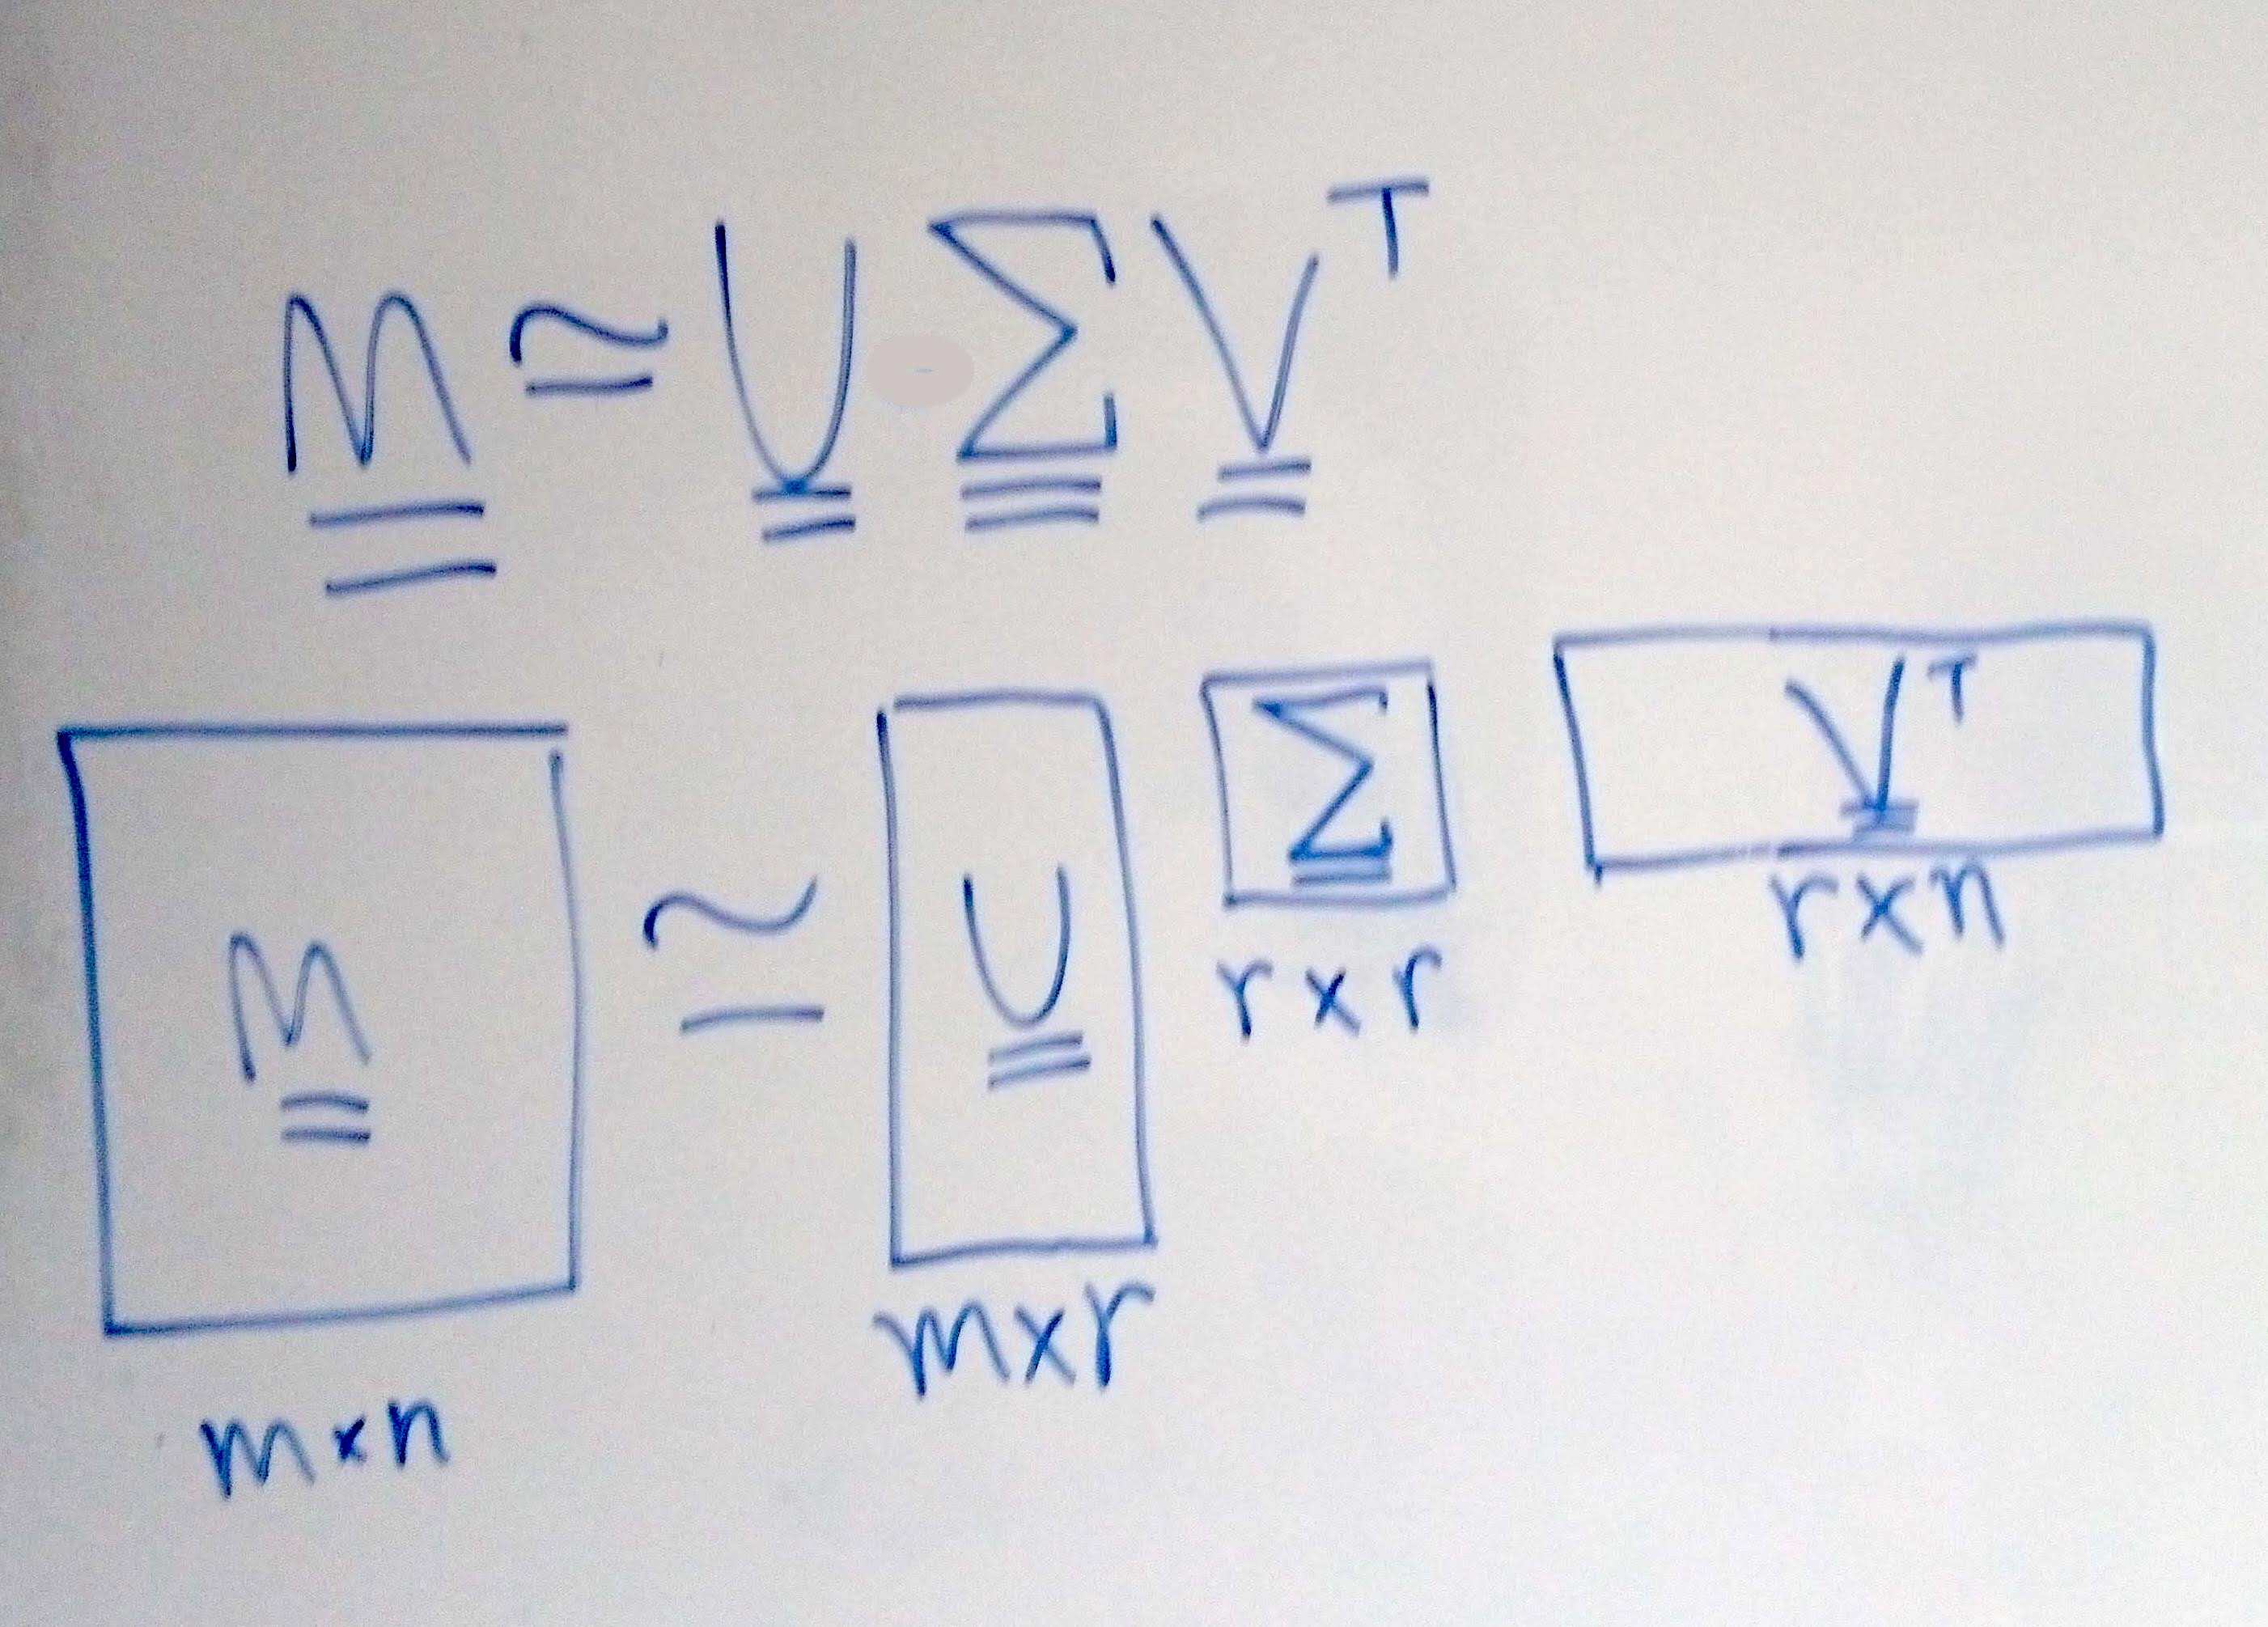

In [54]:
print('Figure 1 - SVD formula')
print("\n")
Image(filename='img/equation.jpg', width=700, height=700) 

Figure 2 - Document Term matrix, our starting point




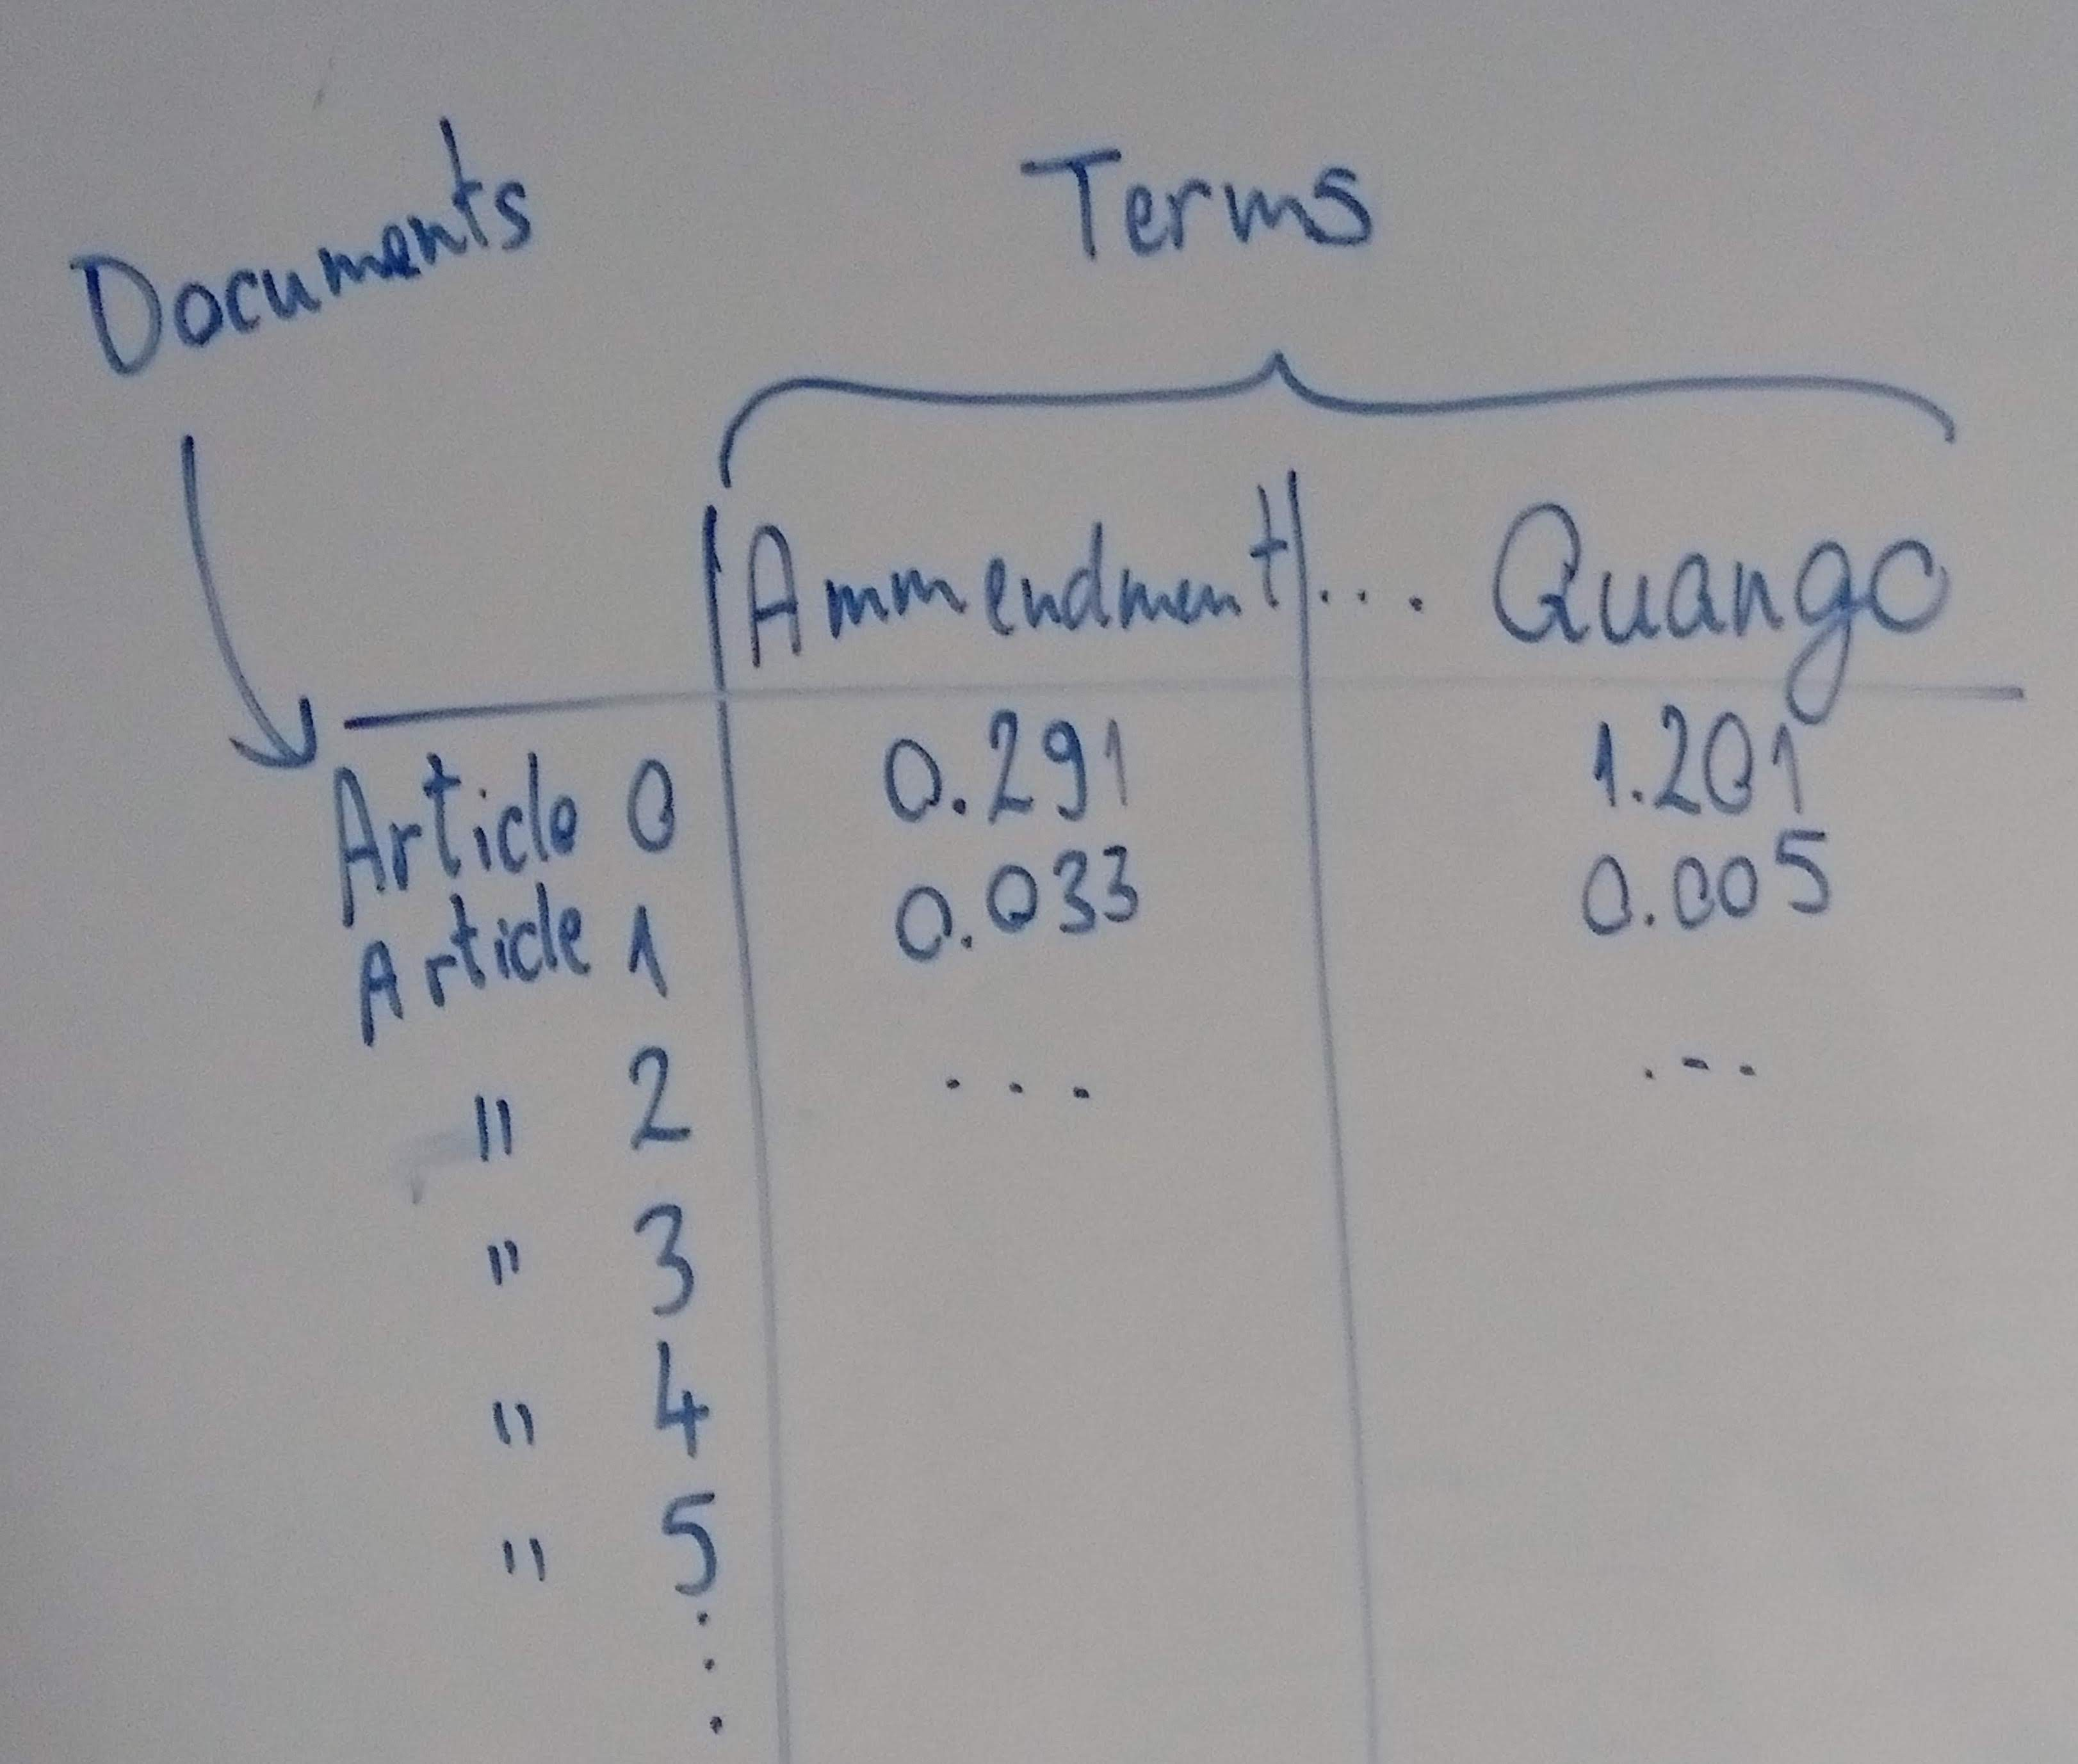

In [61]:
print('Figure 2 - Document Term matrix, our starting point')
print("\n")
Image(filename='img/document_term_matrix.jpg', width=700, height=700, metadata={'title':'Document Term matrix; Figure 1'}) 

##### Intuition
Suppose that we have some table of data, in this case text data, where each row is one document, and each column represents a term. This is the standard way to represent data (in a *document-term matrix*, as shown in Figure 2). 

Now the different documents will have different topics, let's say it's all political articles and there are 3 topics: foreign policy, elections and reform. Let's say that there are articles squarely belonging to each category, some that are in two and some that belong to all 3 categories. We could plot a table where we have each row being a different document (a news article) and each column being a different topic. In the cells we would have a different numbers that indicated how strongly that document belonged to the particular topic (see Figure 3). 


Figure 3 - our imagined Document Topic matrix




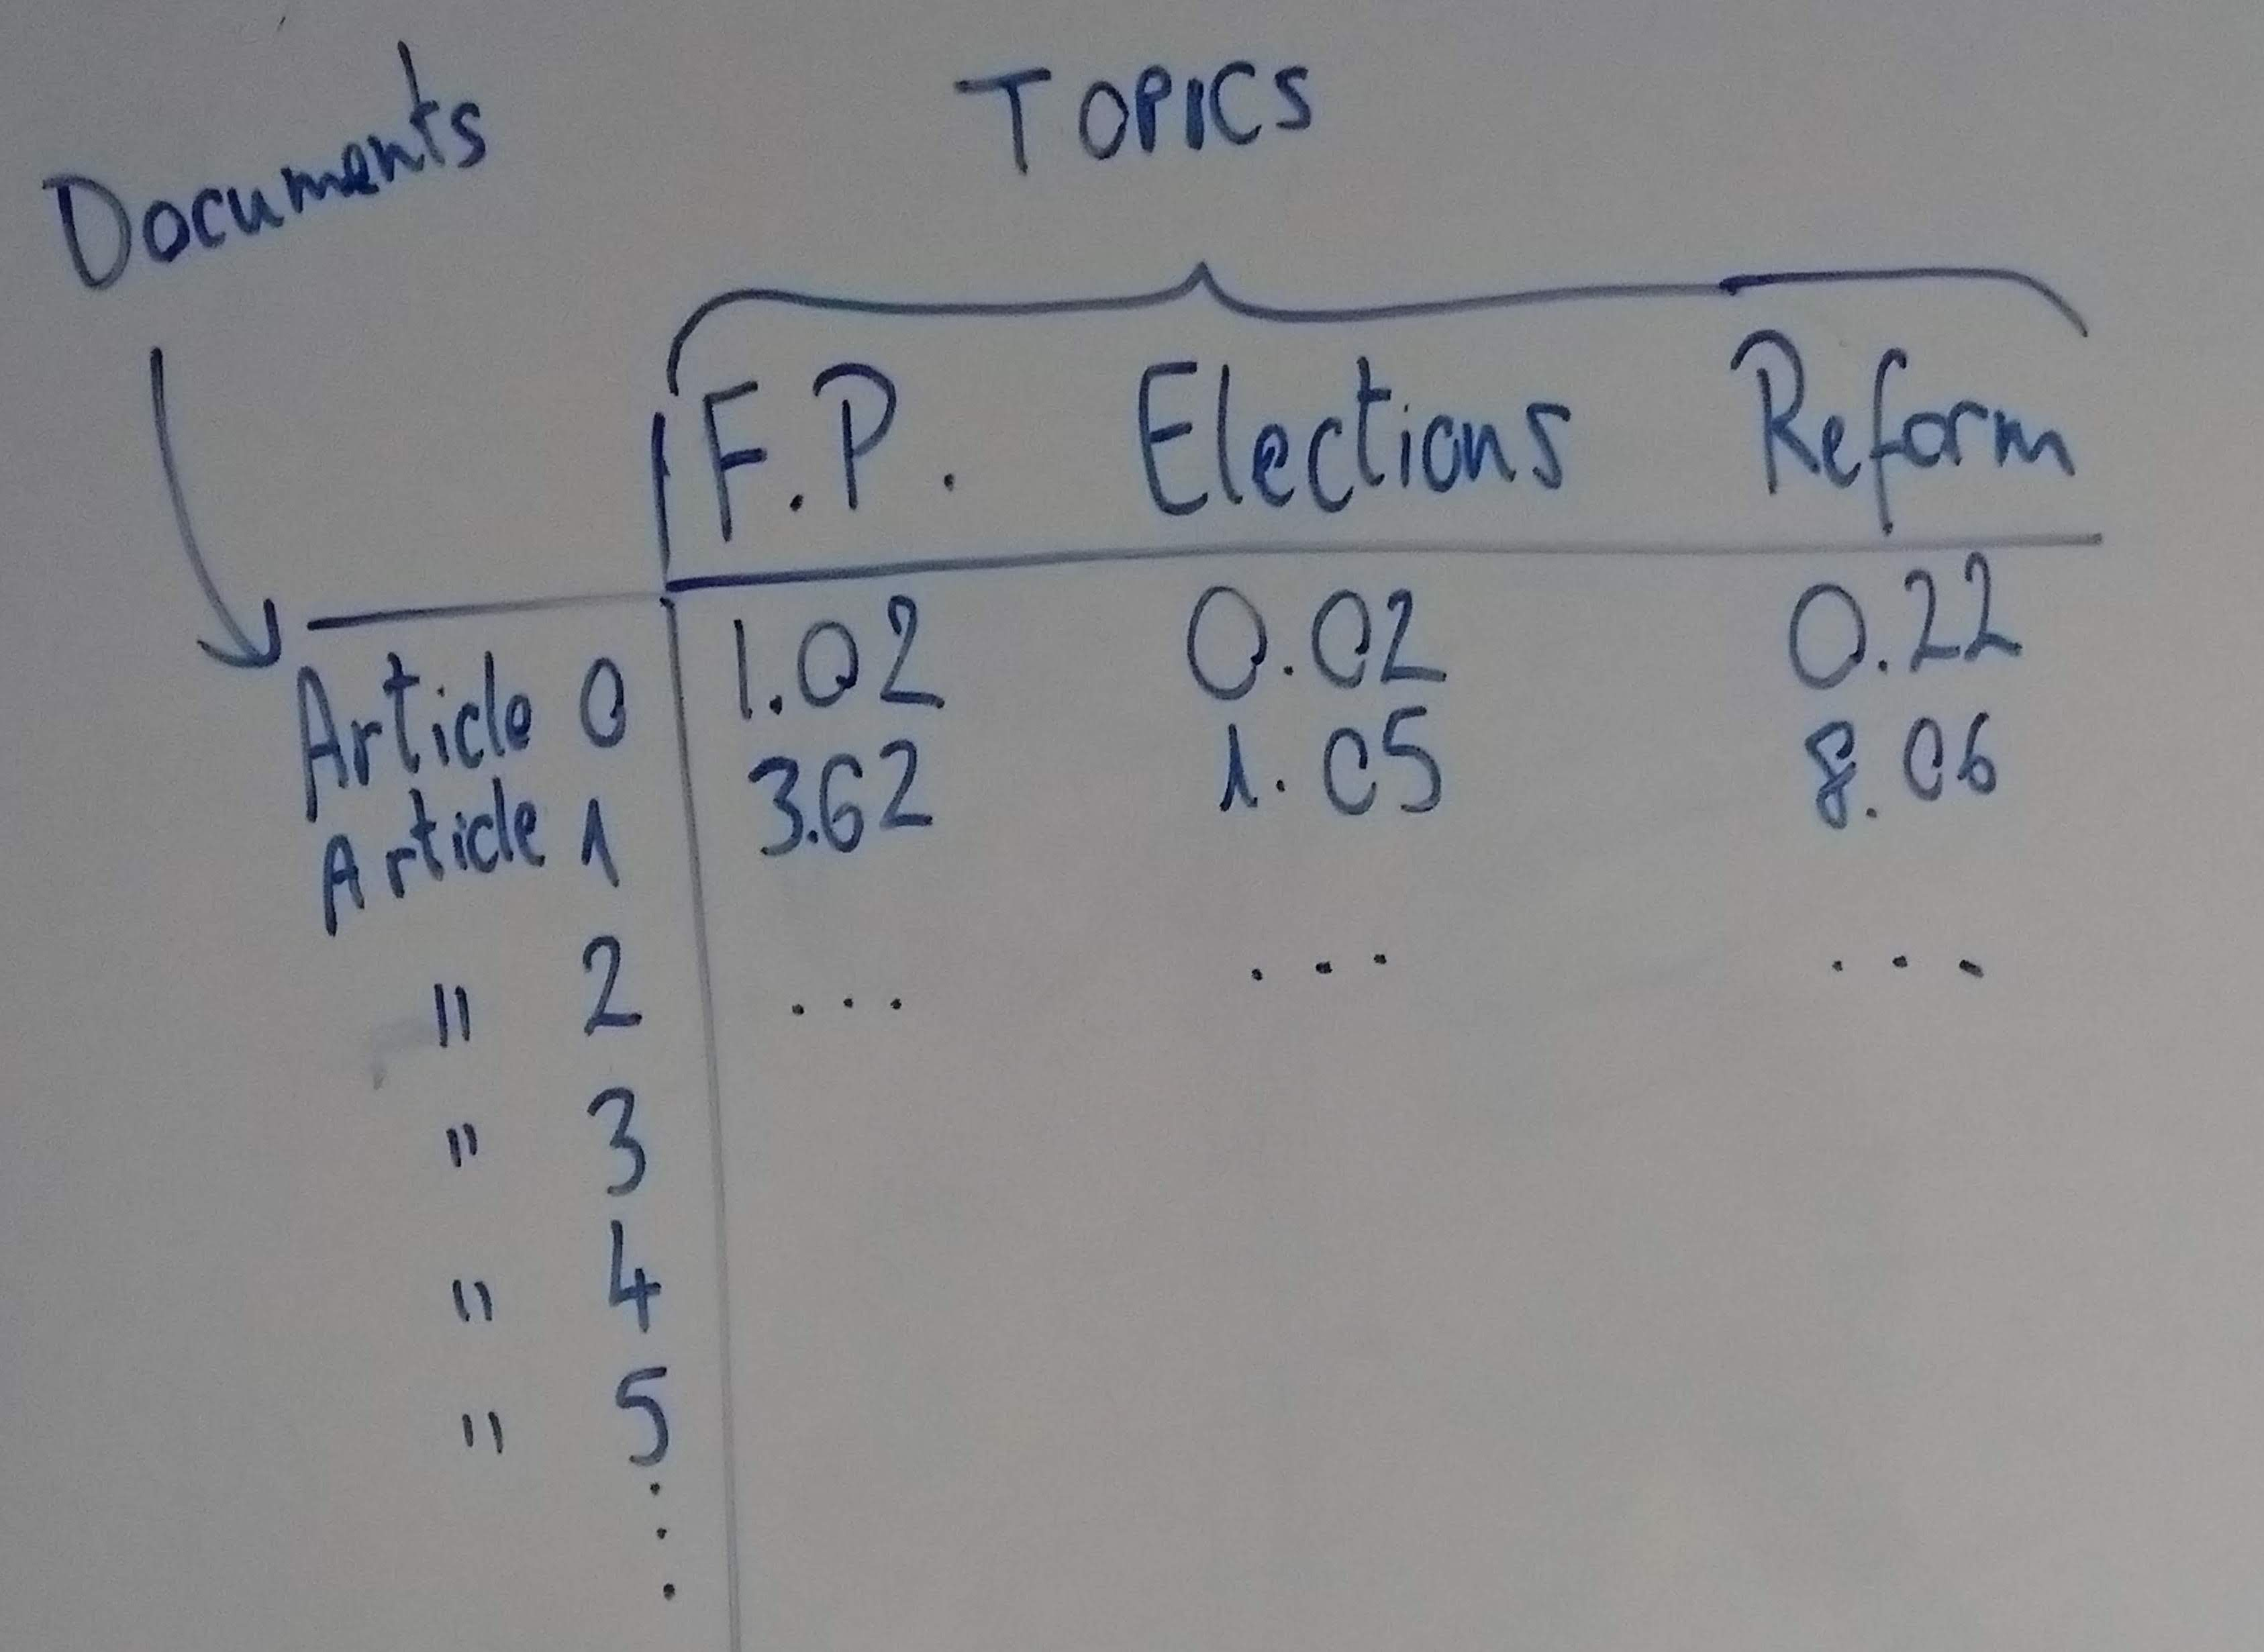

In [56]:
print('Figure 3 - our imagined Document Topic matrix')
print("\n")
Image(filename='img/document_topic.jpg', width=700, height=700) 


Now if we shift our attention conceptually to the **topics** themselves, we should ask ourselves the following question:
- Do we expect certain words to turn up more often in either of these topics? 

If we're looking at foreing policy, we might see terms like "Middle East", "EU", "embassies". For elections it might be "ballot", "candidates", "party"; and for reform we might see "bill", "ammendment" or "corruption". So, if we plotted these topics and these terms in a different table, where the rows are the terms, we would see scores plotted for each term according to which topic it most strongly belonged to. Naturally there will be terms that feature in all three documents ("prime minister", "Parliament", "decision") and these terms will have scores across all 3 columns that reflect how much they belong to either category - the higher the number, the greater its affiliation to that topic. So, our second table (Figure 4) consists of terms and topics. 



Figure 4 - Term-Topic matrix: what words go with which topic; Note that we'll be flipping this matrix




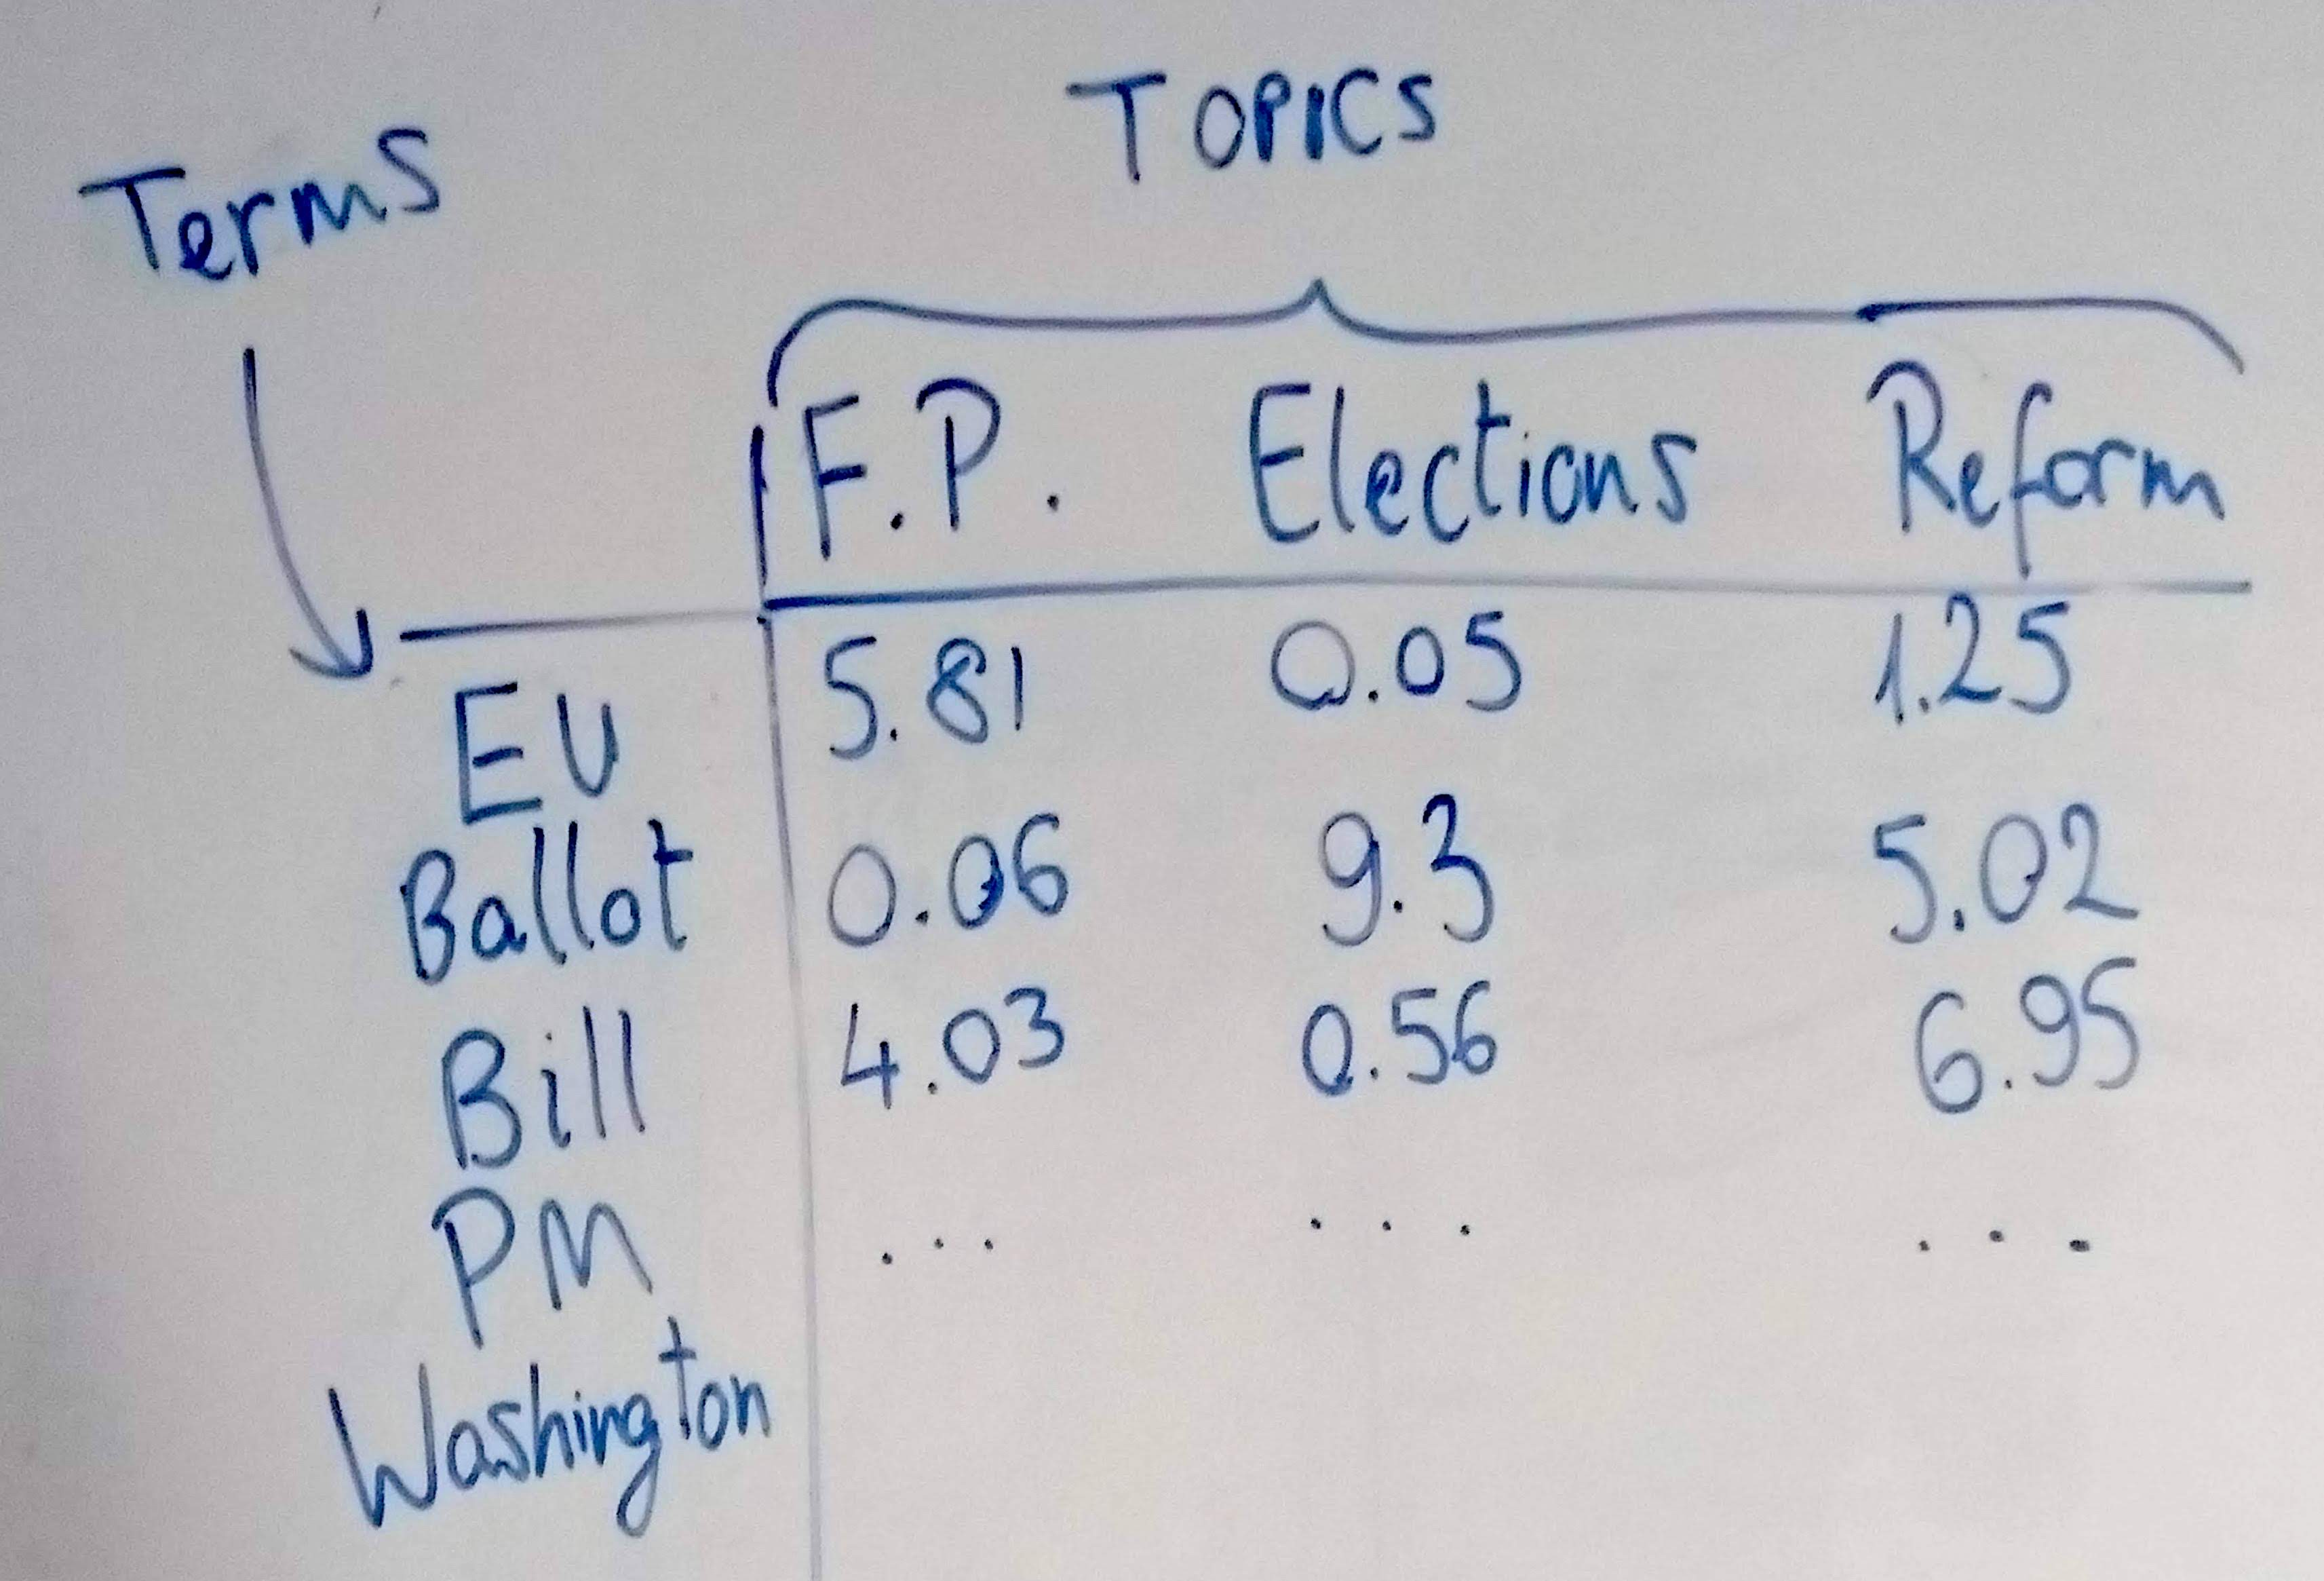

In [57]:
print('Figure 4 - Term-Topic matrix: what words go with which topic; Note that we\'ll be flipping this matrix')
print("\n")
Image(filename='img/term_topic.jpg', width=700, height=700) 


Now the last component is a bit trickier to explain as a table. It's actually a set of numbers, one for each of our topics. What do the numbers represent? They represent how much each of the topics *explains* our data. 

How do I mean "explain"? Well, suppose that actually, "reform" wasn't really a salient topic across our articles, and the majority of the articles fit in far more comfortably in the "foreign policy" and "elections". Thus "reform" would get a really low number in this set, lower than the other two. An alternative is that maybe all three numbers are actually quite low and we actually should have had four or more topics - we find out later that a lot of our articles were actually concerned with economics! By sticking to just three topics we've been denying ourselves the chance to get a more detailed and precise look at our data. The technical name for this array of numbers is the "singular values".

Figure 5 - Topic importance - the Singular Values




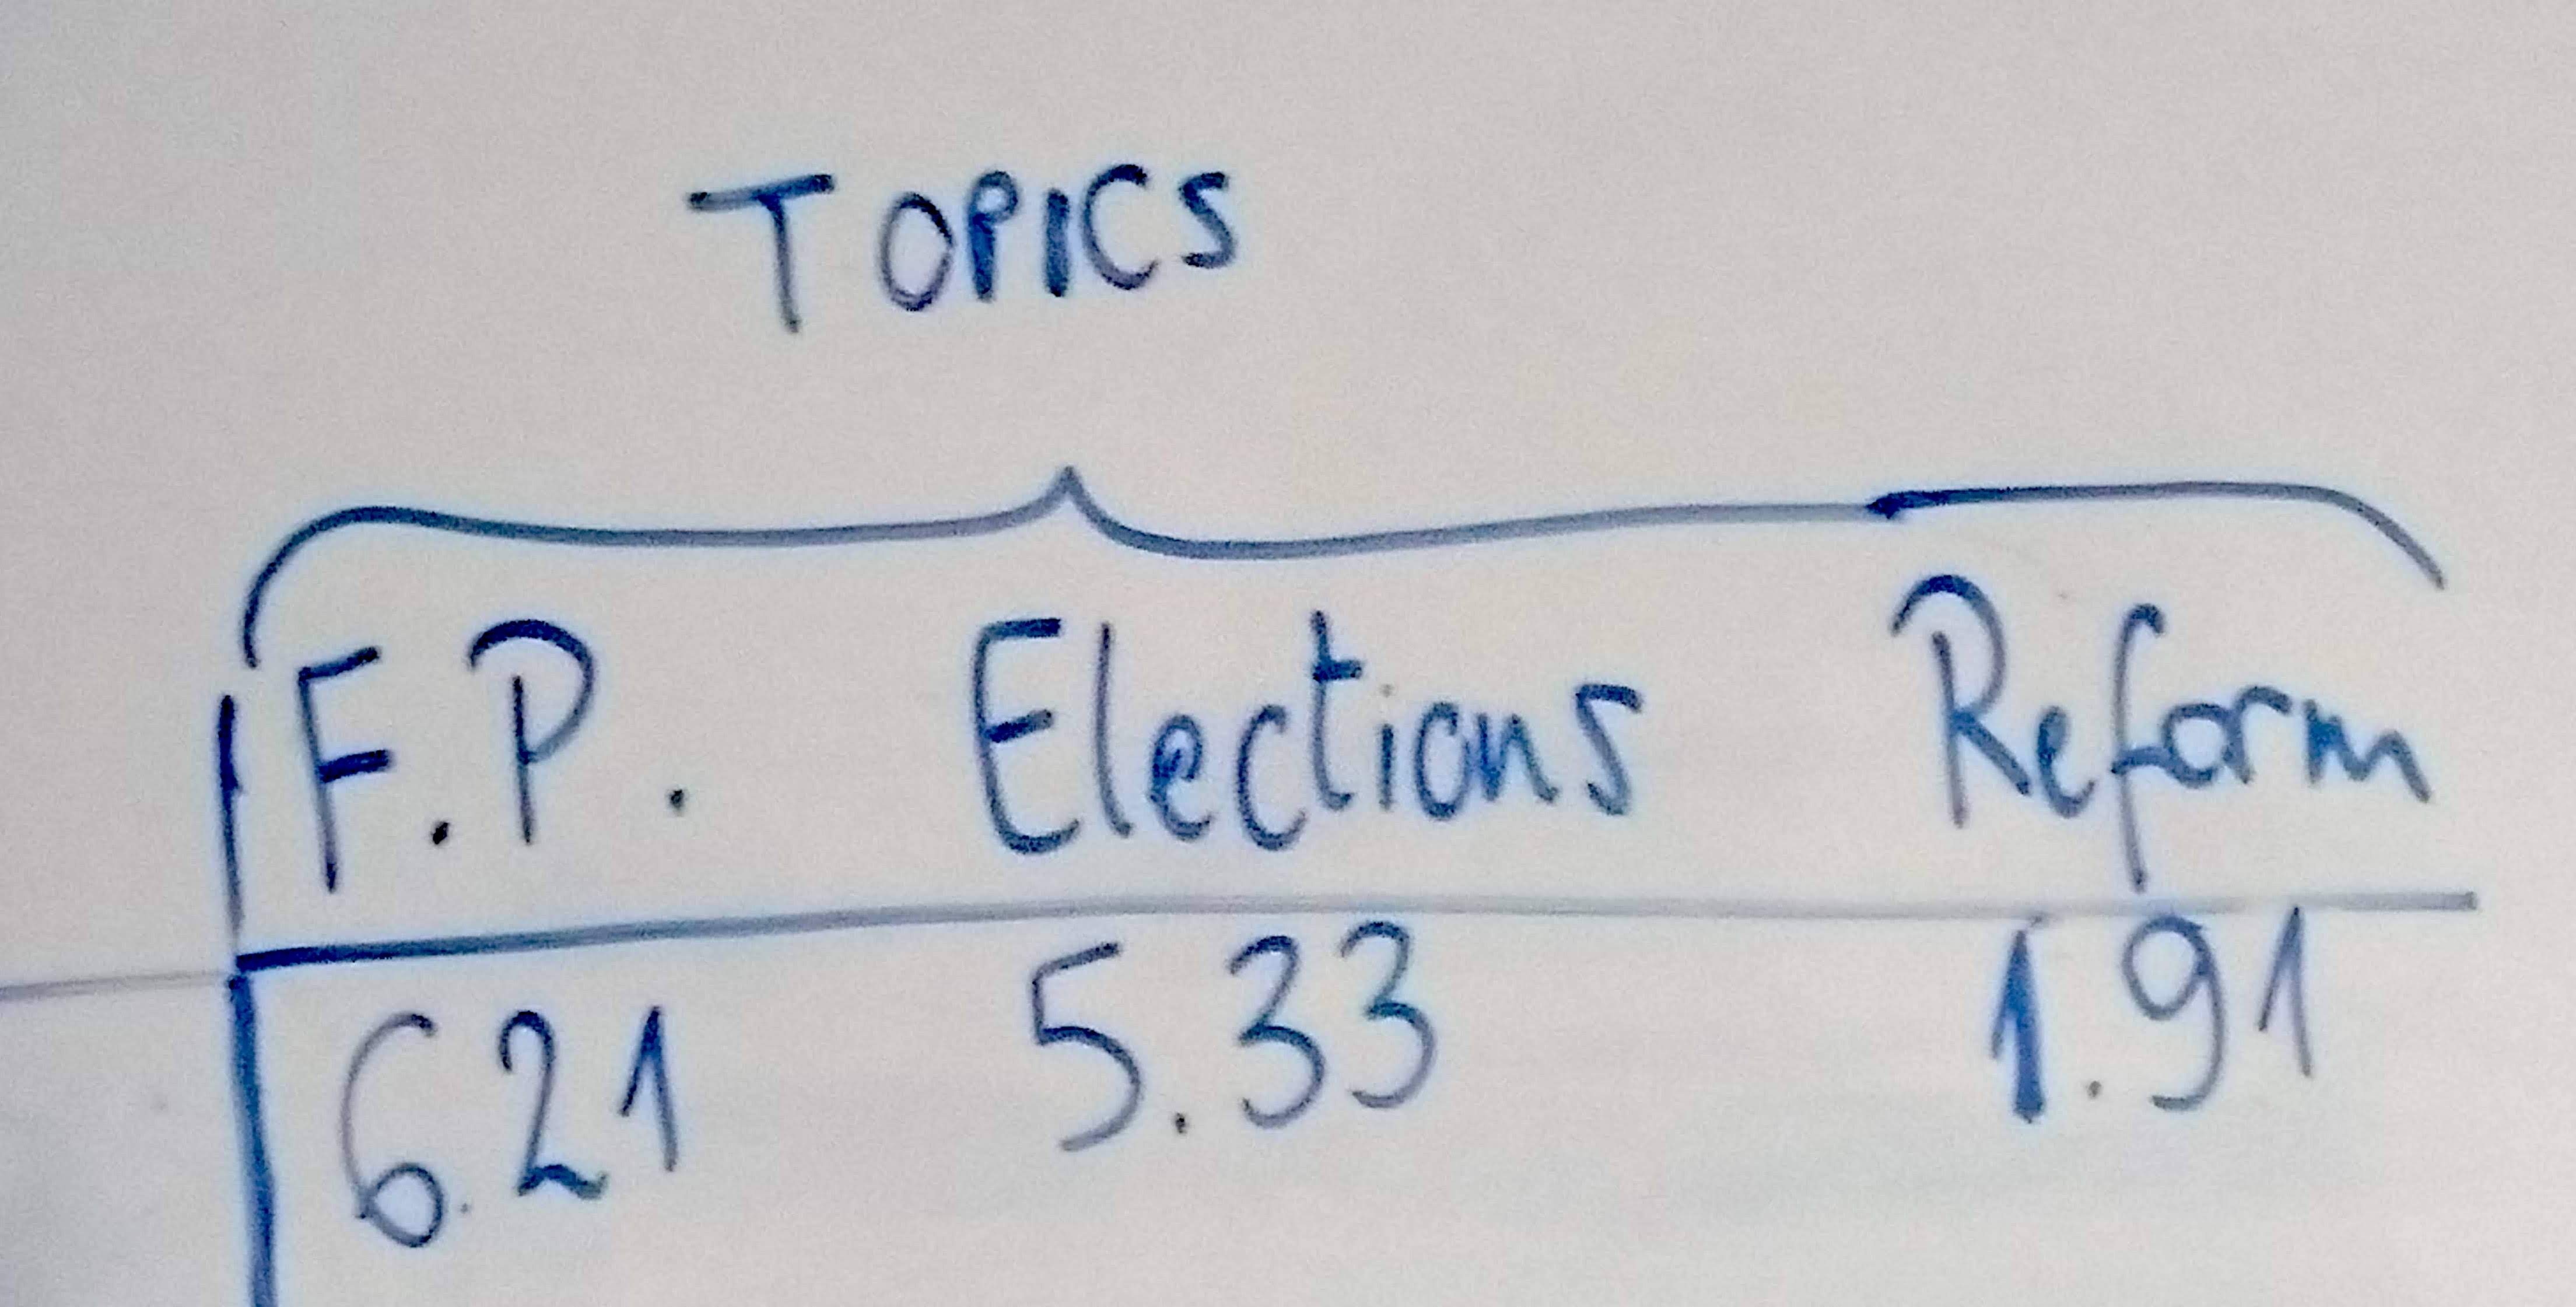

In [58]:
print('Figure 5 - Topic importance - the Singular Values')
print("\n")
Image(filename='img/singular_values.jpg', width=350, height=350) 

Now that's the intuition so far. You'll notice that our two tables have one thing in commont (the documents / articles) and all three of them have one thing in common - the topics, or some representation of them. When we perform LSA, we're normally trying to retrieve the first table, the documents to topics one. 
Now let's explain how this is a dimensionality reduction technique. It's easier to see the merits if we specify a number of documents and topics. 
Suppose we had 100 articles and 10'000 different terms (just think of how many unique words there would be all those articles, from "ammendment" to "zealous"!). In our original document-term matrix that's 100 rows and 10'000 columns. 
When we start to break our data down into the 3 components, we can actually choose the number of topics - we could actually choose for there to be 10'000 different topics, if we genuinely thought there were 10'000 topics present in this corpus. However, we could probably represent the data with far fewer topics, let's say the 3 we originally talked about. That means that in our document-topic table, we'd slash about *99'997 columns*, and in our term-topic table, we'd do the same. In Figure 6 the clipped columns and rows are shown as hashed rectangles. M is the original document-term table; U is the document-topic table, ${\Sigma}$ is the array of singular values and $V{^T}$ is the document-topic table, but flipped on its diagonal (I'll explain why in the math section).

Figure 6 - the hashed parts are the bits we discard




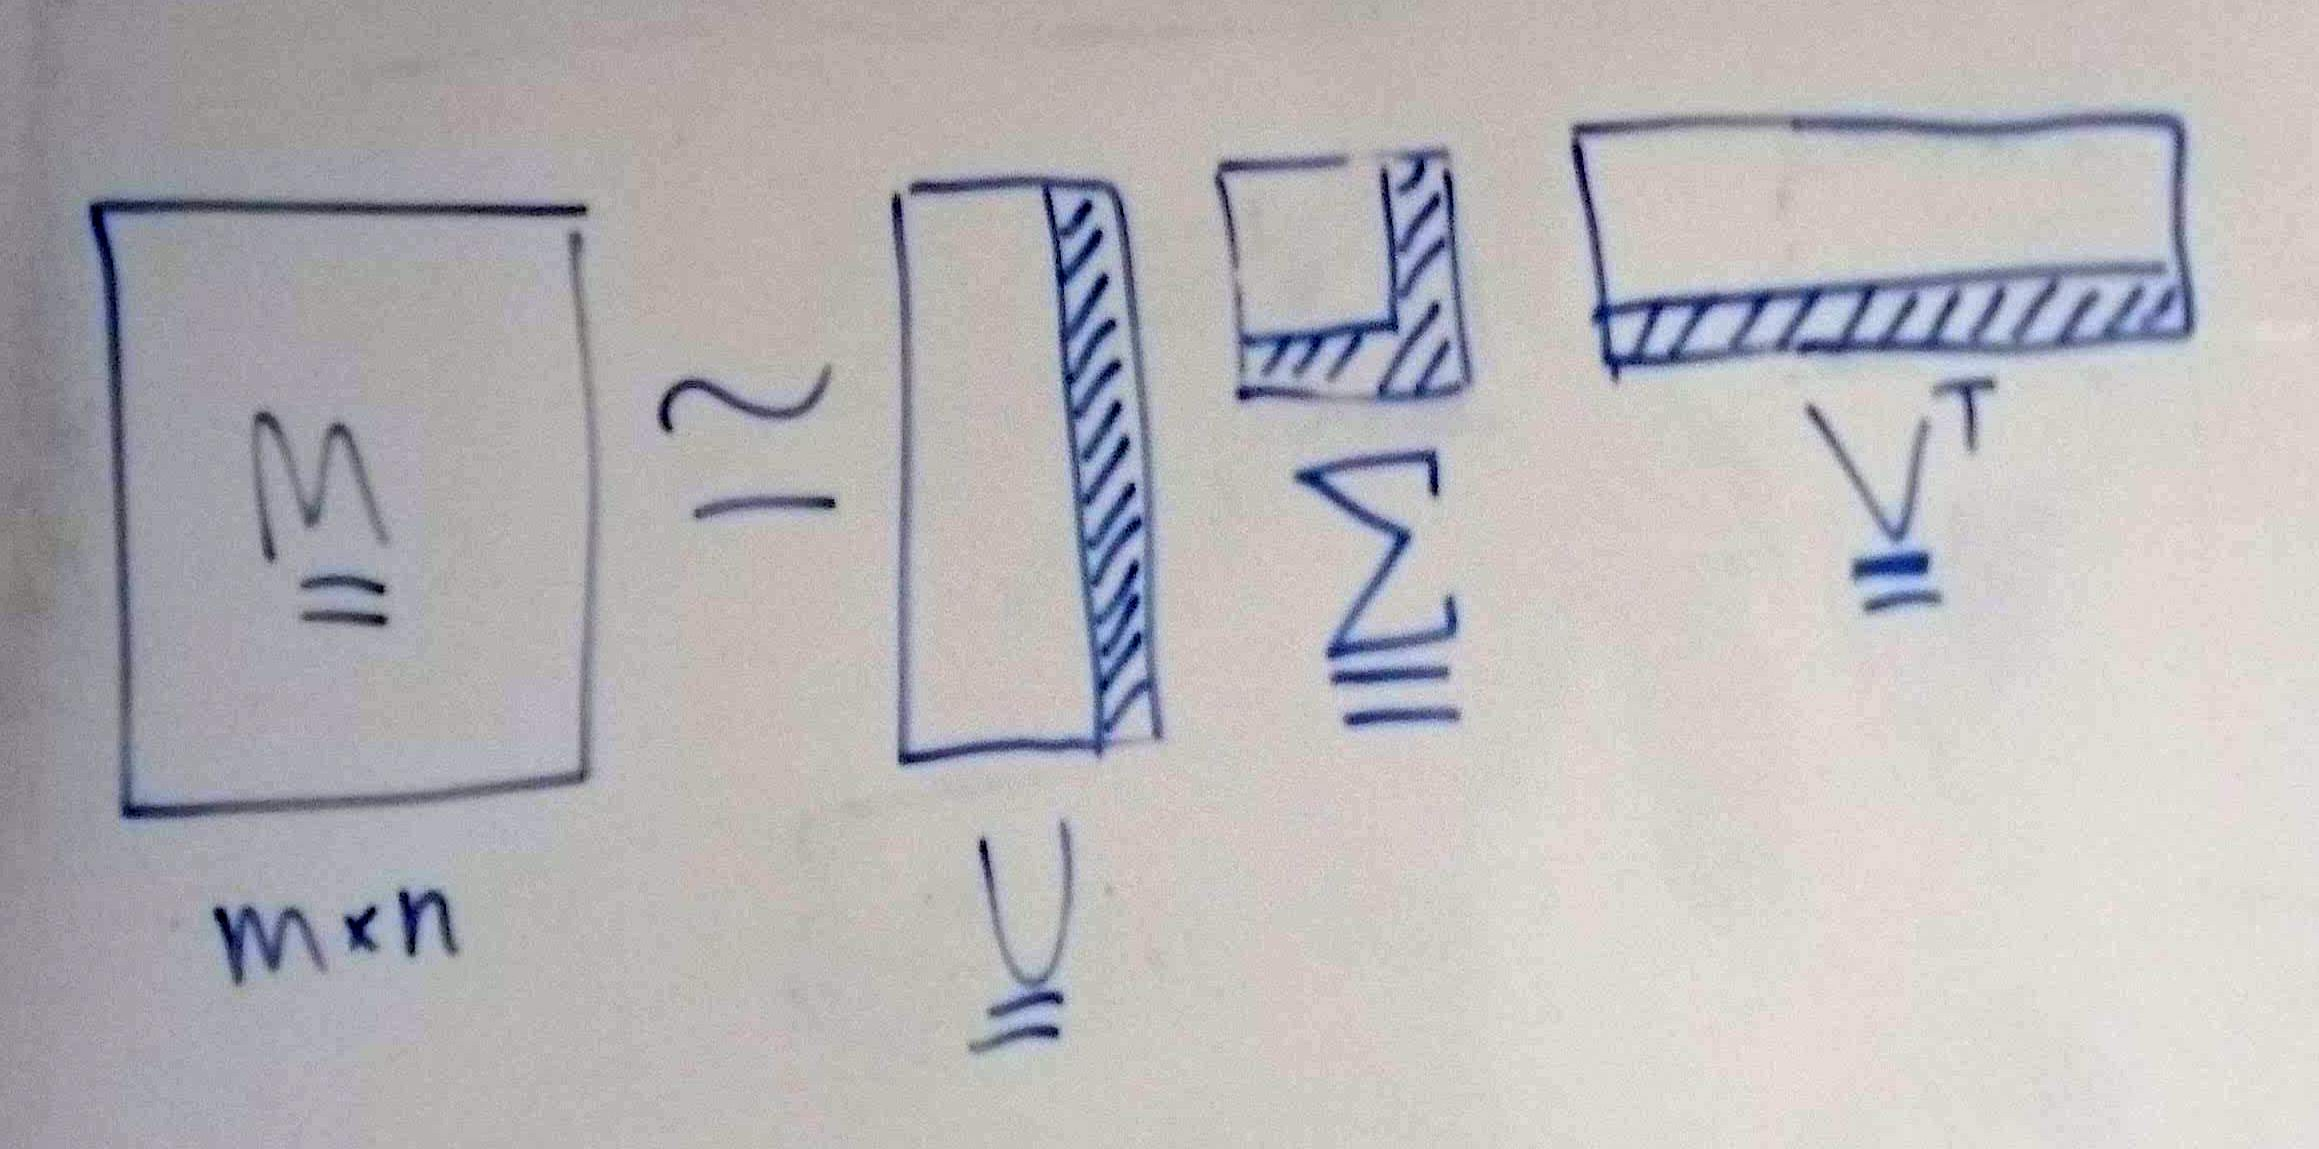

In [59]:
print('Figure 6 - the hashed parts are the bits we discard')
print("\n")
Image(filename='img/matrices_trunc.jpg', width=500, height=400) 

As for the set of numbers denoting topic importance, from a set of 10'000 numbers, each number getting smaller and smaller as it corresponds to a less important topic, we cut down to only 3 numbers, for our 3 remaining topics.
This is why the python implementation for LSA is called *Truncated* SVD by the way: we're cutting off part of our table, but we'll get to the maths in a bit. 

Now, if we take our new, truncated tables, when we combine them together (mathematically this will just be matrix multiplication), we don't get the full dataset back, BUT we get a *lower-dimensional* representation of the dataset - this is exactly what we wanted. It's as if we've compressed the data and now we're seeing how much of the original information has been preserved. 

Of course, we don't just want to return to the original dataset: we now have 3 lower-dimensional components we can use. In the code and maths parts we'll go through which one we actually take forward. In brief, once we've truncated the tables (matrices), the product we'll be getting out is the document-topic table (U) *times* the singular values ( ${\Sigma}$ ). We could intuitively interpret this product as something like "a table showing how much each document belongs to each topic *weighted by* the importance of the topic". 

### Maths

As I said before, SVD is very math heavy, so here goes nothing!

Our original (sample) dataframe is a (20,325) matrix - 20 rows; 325 columns. We will be **factorizing** this matrix into constituent matrices. When I say factorizing this is essentially the same as when we're taking a number and representing it its factors, which when multiplied together, give us the original number, e.g. $ A = B * C * D $

This is also why it's called Singular Value **Decomposition** - we're *decomposing* it into its constituent parts. 

#### $$ \underline{\underline{M}} = \underline{\underline{U}} * \underline{\underline{\Sigma}} * \underline{\underline{V}} ^{T} $$

* where M is our original (m, n) data matrix - m rows, n columns; m documents, n terms
* U is a (m, r) matrix - m documents and r *concepts*
* $ {\Sigma} $ is a *diagonal* (r,r) matrix - all values except those in the diagonal are zero. (But what do the non-zero values represent? Why r*r? 
* V is a (n,r) matrix - n terms, r concepts - what shape will it have when transposed?






Now that extra dimension that wasn't available to us on the left-hand side, the *r* dimension, is the amount of *latent concepts*. Generally we're trying to represent our matrix as components that have one of their axes being this set of components. You will also note that, based on dimensions, the multiplication of the 3 matrices (when V is transposed) will lead us back to the shape of our original matrix, the *r* dimension effectively dissappearing. 

What matters in understanding the math is not the algebraic algorithm by which each number in U, V and ${\Sigma}$ is determined, **but** the mathematical properties of these products and how they relate to each other. 

First of all, it's important to consider first what a matrix actually is and what it can be thought of - a transformation on vector space.
In the figure 


The Wikipedia entry on SVD has a particularly good explanation and GIF of the process (https://en.wikipedia.org/wiki/Singular_value_decomposition), so I recommend that page.



Figure 7
Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann


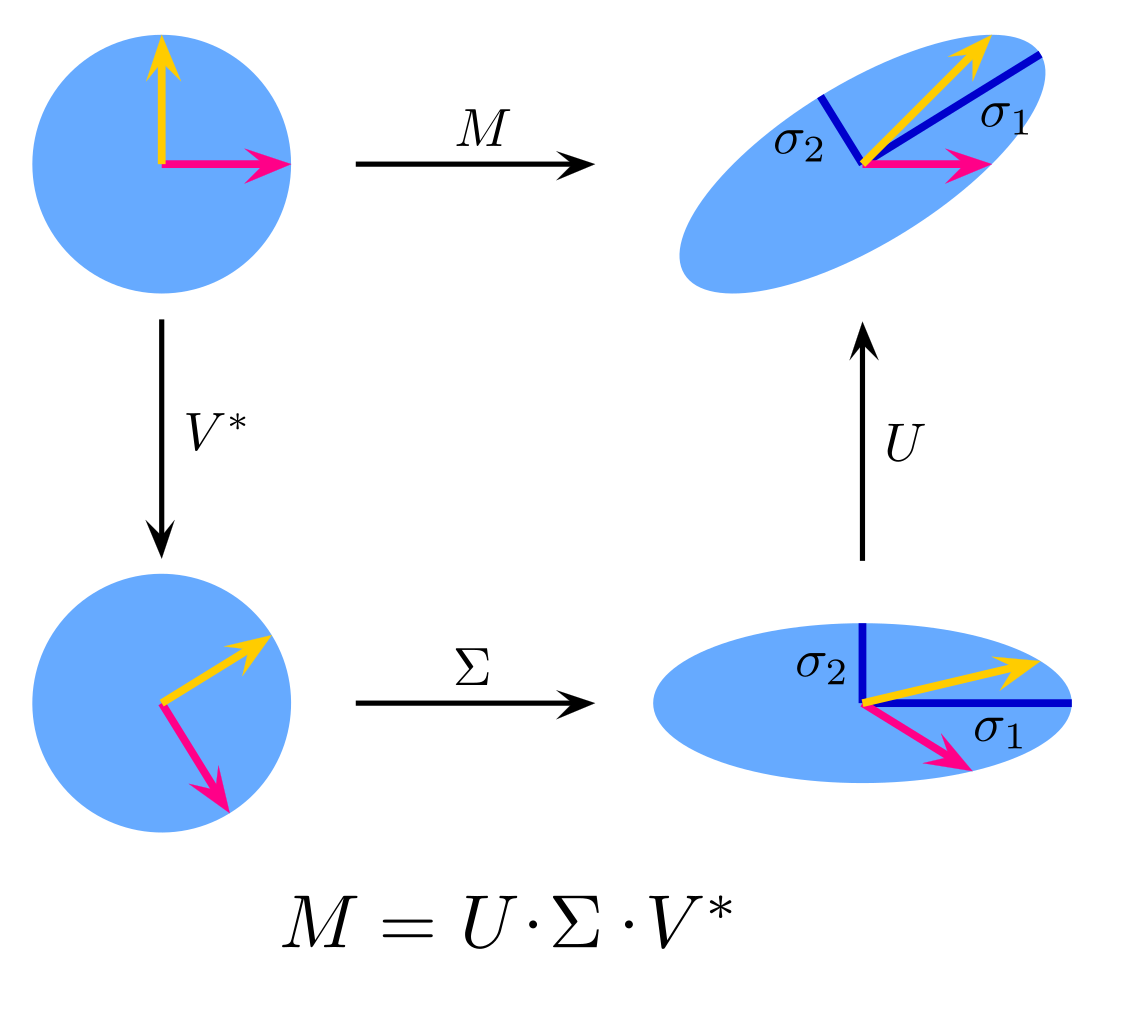

In [60]:
print('Figure 7')
print("Source: Wikipedia: Singular Value Decomposition; link: https://commons.wikimedia.org/wiki/File:Singular-Value-Decomposition.svg#filelinks; Author : Georg-Johann")
Image(filename='img/svd_wikipedia.png', width=500, height=400) 


In [111]:
print('Number of columns  in our dataset is:', len(sample_exp.columns))
sample_exp

Number of columns  in our dataset is: 325


able  absolute  acceleration    access  actually       add  addition  \
0   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.148713   
1   0.000000  0.000000      0.132307  0.000000   0.00000  0.218730  0.000000   
2   0.000000  0.000000      0.000000  0.096939   0.10743  0.000000  0.000000   
3   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
4   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
5   0.000000  0.000000      0.000000  0.072726   0.00000  0.000000  0.000000   
6   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
7   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
8   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
9   0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
10  0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
11  0.000000  0.268623      0.000000  0.000000   0.00000  0.000000  0.000000   
12  0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
13  0.000000  0.000000      0.000000  0.000000   0.00000  0.126621  0.102122   
14  0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
15  0.000000  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
16  0.137297  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
17  0.000000  0.031950      0.031950  0.000000   0.06390  0.026410  0.000000   
18  0.445776  0.000000      0.000000  0.000000   0.00000  0.000000  0.000000   
19  0.000000  0.000000      0.000000  0.288065   0.00000  0.263883  0.000000   

       agree    almost   already  ...     worse    worth     would   writers  \
0   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  ...  0.000000  0.10743  0.000000  0.000000   
3   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.000000   
4   0.000000  0.000000  0.156392  ...  0.000000  0.00000  0.000000  0.000000   
5   0.080597  0.000000  0.000000  ...  0.000000  0.00000  0.085339  0.000000   
6   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.073530   
8   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.131237  0.000000   
9   0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.048395  0.000000   
10  0.000000  0.000000  0.000000  ...  0.000000  0.22150  0.117266  0.000000   
11  0.000000  0.000000  0.000000  ...  0.067156  0.00000  0.035553  0.000000   
12  0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.000000  0.000000   
13  0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.081098  0.000000   
14  0.000000  0.000000  0.141833  ...  0.000000  0.00000  0.000000  0.000000   
15  0.190959  0.190959  0.000000  ...  0.000000  0.00000  0.303290  0.000000   
16  0.000000  0.000000  0.000000  ...  0.137297  0.00000  0.072687  0.137297   
17  0.000000  0.063900  0.000000  ...  0.000000  0.00000  0.101489  0.000000   
18  0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.236002  0.000000   
19  0.000000  0.000000  0.000000  ...  0.000000  0.00000  0.084506  0.000000   

      writes   writing     wrong      year     years       yet  
0   0.000000  0.000000  0.000000  0.000000  0.122926  0.000000  
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3   0.091326  0.000000  0.000000  0.000000  0.000000  0.000000  
4   0.092476  0.000000  0.000000  0.000000  0.000000  0.156392  
5   0.190631  0.000000  0.000000  0.072726  0.000000  0.000000  
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7   0.043479  0.000000  0.000000  0.000000  0.000000  0.000000  
8   0.000000  0.000000  0.000000  0.000000  0.000000  0.00000

In [43]:
svd = TruncatedSVD(n_components=10, n_iter=100, random_state=42)

sample_decomp = svd.fit_transform(sample_exp.to_numpy())
Sigma = svd.singular_values_
U = sample_decomp/Sigma
V_T = svd.components_

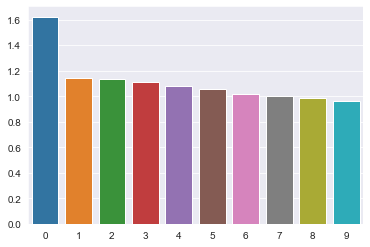

In [44]:
sns.barplot(x=list(range(len(Sigma))), y = Sigma)

In [45]:
V_T.shape

(10, 325)

In [126]:
# We're going to do the full, un-truncated SVD, for illustrative purposes
# unfortunately TruncatedSVD (a wrapper function) only accepts n_components
# less than n_features, so we'll be using randomized_svd, the OG SVD sklearn 
# function.
U, Sigma, V_T = randomized_svd(M = sample_exp.to_numpy(), n_components=20,
                    n_iter= 200, random_state=12345, transpose=False)

U

array([[ 2.30424196e-01, -3.30092074e-01,  2.22224616e-01,
         4.49558777e-01,  3.20452388e-02,  3.40295485e-02,
         4.50455986e-02, -7.09718961e-02, -3.41587590e-02,
        -4.25906940e-01, -1.46231345e-02,  7.21052821e-02,
        -6.63933000e-02, -9.52413370e-02,  1.21205478e-01,
         4.76973759e-02, -1.29868943e-01, -3.09818610e-02,
        -2.01668799e-01, -5.47985905e-01],
       [ 1.95077155e-01,  2.10601254e-01,  3.86450474e-01,
        -7.75207654e-02, -2.58400149e-01, -8.19916416e-02,
         4.89693366e-01, -1.35384506e-01,  9.16101691e-04,
         1.15143550e-01, -1.40985293e-01, -3.81243735e-02,
         2.85052261e-02, -1.23177648e-01, -2.49589172e-01,
         1.65558845e-01, -2.96710987e-01,  2.37681961e-01,
        -3.47997020e-01,  1.57180594e-01],
       [ 2.88059817e-01,  1.60352759e-02,  7.59939515e-02,
        -1.32851500e-01, -2.72366800e-01, -1.07135654e-01,
        -3.48739621e-01,  2.75404287e-01, -6.17950175e-02,
        -1.93632772e-01,  1.6

In [127]:
Sigma

array([1.62270596, 1.14152868, 1.1307284 , 1.11272151, 1.07953239,
       1.05712135, 1.0145306 , 0.99992768, 0.98285807, 0.9639876 ,
       0.93353336, 0.92611605, 0.91671171, 0.89872399, 0.87999671,
       0.86742211, 0.82598611, 0.79101092, 0.77016585, 0.73114533])

In [128]:
V_T

array([[ 0.07564033,  0.05186719,  0.02179741, ...,  0.10727774,
         0.10158662,  0.02545101],
       [ 0.06066141, -0.04478237,  0.01439389, ..., -0.13425101,
        -0.14413652,  0.00384995],
       [-0.15128008, -0.04146865,  0.04633781, ..., -0.01674779,
         0.00214097, -0.04073327],
       ...,
       [-0.00671692,  0.05974689,  0.0363214 , ..., -0.03892498,
        -0.0582916 , -0.00674834],
       [-0.11986735, -0.09510381, -0.05091786, ...,  0.11537816,
         0.10342137,  0.00339932],
       [ 0.09129616,  0.00849547,  0.05732546, ...,  0.41921291,
         0.13027465,  0.02293766]])

In [129]:
print("U           - ",U.shape)
print("Sigma       - ",Sigma.shape)
print("V_transpose - ",V_T.shape)

U           -  (20, 20)
Sigma       -  (20,)
V_transpose -  (20, 325)


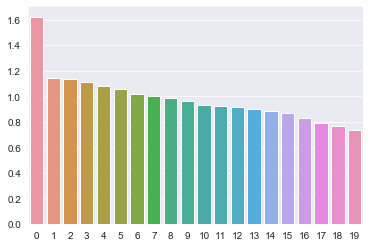

In [130]:
sns.barplot(x=list(range(len(Sigma))), y=Sigma)

In [135]:
# and ofc we could get part of our original dataset back
low_dim_data = np.matmul(np.matmul(U, Sigma), V_T)
low_dim_data

array([ 6.03124738e-03, -2.01121425e-01,  1.84798882e-01,  8.72191169e-02,
       -1.34058908e-01,  1.98589457e-01, -1.43054733e-01, -2.88759840e-02,
       -1.62465906e-01, -3.54214996e-02,  7.03183437e-02, -3.05287886e-01,
       -1.56910416e-01,  1.76411552e-01, -1.73112295e-01,  7.66485542e-02,
       -1.45808074e-01,  1.51652994e-01, -4.04027053e-01,  7.52510010e-01,
       -1.22517898e-01, -8.81273989e-02, -1.87942519e-01,  3.48164525e-02,
        1.12572245e-01,  2.92850925e-02,  5.75046389e-01, -1.46523631e-01,
       -6.52416829e-01,  3.10831899e-01, -8.05805384e-02,  1.63823424e-01,
        2.24240395e-01, -1.48813394e-01,  3.78108931e-01, -2.18734864e-01,
       -8.58950013e-02,  2.54267424e-01,  2.02705923e-01, -1.15668340e-01,
       -4.68416137e-02,  1.30812674e-01,  6.46691513e-01, -1.58109327e-02,
       -7.79057491e-02,  2.72516576e-01,  3.46530439e-02,  2.90904749e-01,
       -2.34208069e-02, -9.56632964e-02, -1.55811498e-01, -1.80452233e-01,
       -3.02649007e-01, -

In [136]:
low_dim_data.shape

(325,)

In [137]:
sample_exp.to_numpy().shape

(20, 325)

In [116]:
svd.components_

array([[ 0.28872875,  0.25646754,  0.21403316,  0.27308097,  0.19420214,
         0.2274723 ,  0.19420214,  0.1775887 ,  0.1775887 ,  0.21403316,
         0.2274723 ,  0.31274303,  0.21403316,  0.27308097,  0.2274723 ,
         0.1775887 ,  0.2274723 ,  0.2274723 ,  0.19420214],
       [-0.11088417, -0.12758466,  0.254549  , -0.41253146, -0.21386518,
         0.04339792, -0.21386518,  0.07108162,  0.07108162,  0.254549  ,
         0.04339792,  0.5242969 ,  0.254549  , -0.41253146,  0.04339792,
         0.07108162,  0.04339792,  0.04339792, -0.21386518],
       [-0.09980126, -0.53331574,  0.21925565,  0.05703551,  0.23091948,
         0.03523516,  0.23091948, -0.35943177, -0.35943177,  0.21925565,
         0.03523516,  0.03370784,  0.21925565,  0.05703551,  0.03523516,
        -0.35943177,  0.03523516,  0.03523516,  0.23091948]])

In [117]:
svd.singular_values_

array([1.48083561, 0.70865447, 0.55220895])

#### Code: Scikit-Learn Implementation

Thanks to Scikit-Learn, TruncatedSVD objects are functionally extremely similar to the previous data-transformation objects you've seen before, which makes implementation very straightforward.

The nature of Truncated SVD is such that we can choose the number of final components, whereas a full SVD would explain the entirety of the variance in the data. We're aiming to explain our data (relatively) accurately but with fewer features, so reducing the number of features from 241 to 100 is a significant step in that direction. 



Let's take the first 3 documents (0,1 and 2) of our newsgroups data. We're not gonna get the same clear-cut distinctions as in the example in the Concept section, but we're focussing more on the Python implementation here. We've vectorized our data (represented text as vectors) below:

In [90]:
print('Number of columns  in our dataset is:', len(sample_exp.columns))
sample_exp
# QUESTION: What does tf-idf stand for? 
#
# QUESTION: What does the idf part measure, intuitively?
#
# STRETCH: what's the full formula for tf-idf?  (either the classic formula or the sklearn one will do)
#

Number of columns  in our dataset is: 222


acceleration    access    active  actually  adapters       add  addition  \
0      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.117608   
1      0.095583  0.000000  0.000000  0.000000  0.095583  0.191166  0.000000   
2      0.000000  0.071511  0.071511  0.071511  0.000000  0.000000  0.000000   

    advance    answer  answered  ...   weekend      well      went  whatever  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.117608   
1  0.000000  0.000000  0.095583  ...  0.000000  0.000000  0.000000  0.000000   
2  0.071511  0.071511  0.000000  ...  0.071511  0.143021  0.071511  0.000000   

     willis  wondering     worth       wow       yea     years  
0  0.000000   0.089444  0.000000  0.000000  0.000000  0.117608  
1  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.143021   0.054386  0.071511  0.071511  0.071511  0.000000  

[3 rows x 222 columns]

Here we have taken the most important words and represented what TF-IDF score they have. We've filtered out words under a certain idf score, so we got rid of a lot of words that don't convey any meaning. It's worth noting that this method is generalizable to any kind of real-valued matrix (real as in the numbers in the cells are real, and not complex or imaginary, numbers). 

In our current matrix, we are representing **documents** via **words**. When doing SVD, we assume that within all that jumble of words, across all documents, there must be some set of **concepts** (or topics, if you prefer) and we would prefer to represents the documents through those concepts instead. This will simplify our data and summarize its properties. 

In [35]:
#now we reduce the dimensionality of our tfidf array using PCA, to two dims
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

skl_decomp_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=42)

tfidf_lsa_data = skl_decomp_obj.fit_transform(tfidf_train_df)


In [36]:
skl_decomp_obj.explained_variance_ratio_

array([0.00631212, 0.0258966 , 0.01679788, 0.01374899, 0.01190696,
       0.01118847, 0.01074829, 0.01052689, 0.0103112 , 0.00963623,
       0.00937076, 0.00910335, 0.00883867, 0.00852629, 0.00843441,
       0.00840878, 0.00810704, 0.00802402, 0.00795814, 0.00778352,
       0.00765823, 0.00750661, 0.00735109, 0.00725104, 0.00715867,
       0.00692141, 0.00686116, 0.00674842, 0.00667053, 0.00659952,
       0.00646529, 0.00643741, 0.00629743, 0.00626143, 0.00622319,
       0.00610037, 0.00597814, 0.00592499, 0.00588543, 0.00583777,
       0.00572755, 0.00569112, 0.00563706, 0.00557872, 0.00552598,
       0.00550221, 0.00541925, 0.00540314, 0.0053636 , 0.00533587,
       0.00528411, 0.00525284, 0.00519115, 0.0051132 , 0.005079  ,
       0.00506124, 0.00497664, 0.00496289, 0.00492273, 0.00491785,
       0.00486026, 0.00484847, 0.0048078 , 0.00476367, 0.00472703,
       0.00469831, 0.00464891, 0.00464703, 0.00459812, 0.00456691,
       0.00454626, 0.00450115, 0.00448421, 0.00445247, 0.00439

In [37]:
skl_decomp_obj.explained_variance_ratio_.sum()

0.6217337131085893

In [39]:
# and our data's shape has now been drastically changed
tfidf_lsa_data.shape

(11314, 100)

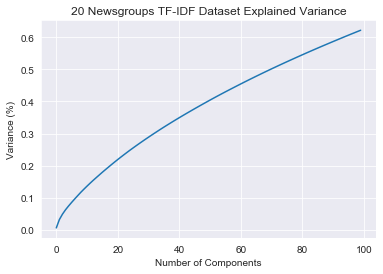

In [19]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(skl_decomp_obj.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('20 Newsgroups TF-IDF Dataset Explained Variance')
plt.show()

So, with 100 components we've managed to account for about a quarter of the variance in our data. This is after we brought it down from 1684 dimensions, so that's a lot of compression. Below I've run a gridsearchCV on a two logistic regression models, on with standard tf-idf data and one without it, to compare. 

In [20]:
logreg_pca = LogisticRegression()
logreg     = LogisticRegression()
logreg_param_grid = [{'penalty':['l1', 'l2']},
                 {'tol':[0.0001, 0.0005, 0.001]}]

# knn_pca.fit(pca_data, y_train)
# knn.fit(x_train_scaled, y_train)

grid_lsa_log = GridSearchCV(estimator=logreg_pca,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)

grid_log = GridSearchCV(estimator=logreg,
                        param_grid=logreg_param_grid, 
                        scoring='accuracy', cv=5,
                        n_jobs=6)


best_lsa_logreg = grid_lsa_log.fit(tfidf_lsa_data, y_train).best_estimator_
best_reg_logreg = grid_log.fit(tfidf_train_df, y_train).best_estimator_

In [21]:
print("ROC AUC of optimized Logistic Regression on validation data with principal components is :", best_lsa_logreg.score(tfidf_lsa_data, y_train))
print("ROC AUC of optimized Logistic Regression with standard validation data is :", best_reg_logreg.score(tfidf_train_df, y_train))

ROC AUC of optimized Logistic Regression on validation data with principal components is : 0.4604030404808202
ROC AUC of optimized Logistic Regression with standard validation data is : 0.5424253137705498


The drop in performance is significant, but you can work this into an optimization pipeline and tweak the number of SVD components. Remember that we're only accounting for 25% of the variance -> that should put our accuracy result into perspective. 
Of course, this is multi-label classification, so it would be best to visualize this with a confusion matrix. 

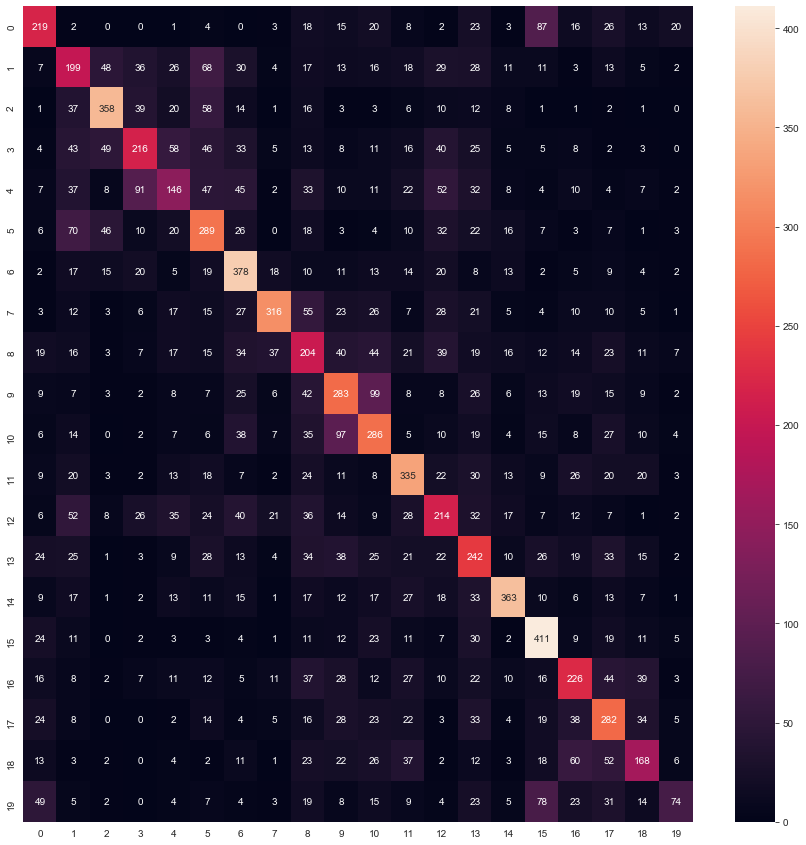

In [22]:
logreg_group_pred = best_lsa_logreg.predict(tfidf_lsa_data)
plt.figure(figsize=(15,15))
sns.heatmap(confusion_matrix(y_train, logreg_group_pred ), 
            annot=True, fmt='.4g');

In [23]:
from mpl_toolkits.mplot3d import Axes3D


I've included below some visualizations of the transformed data, just for the worth of the example code.

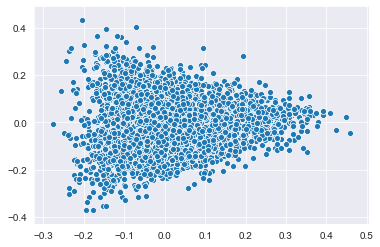

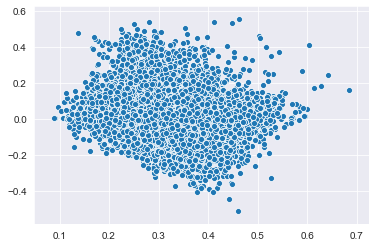

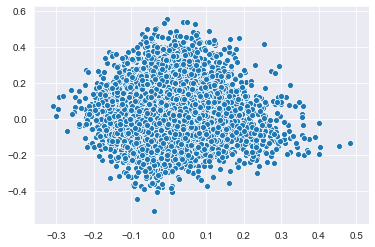

In [24]:
sns.scatterplot(tfidf_lsa_data[:,20], tfidf_lsa_data[:,25])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,0], tfidf_lsa_data[:,2])
plt.show();
sns.scatterplot(tfidf_lsa_data[:,22], tfidf_lsa_data[:,2])
plt.show();


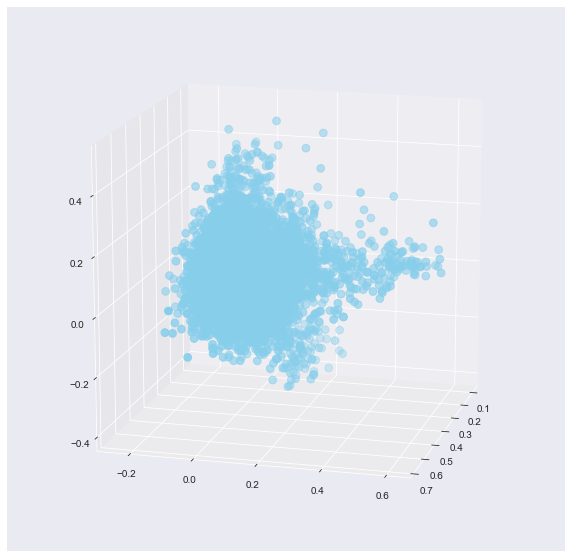

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tfidf_lsa_data[:,0], tfidf_lsa_data[:,15], tfidf_lsa_data[:,9], c='skyblue', s=60)
ax.view_init(15, 15)
plt.show()

## Clustering on LSA-processed data

We're implementing K-means clustering on our transformed data, starting with 20 clusters. 

In [26]:
kmeans = KMeans(n_clusters=20, max_iter=2000, algorithm = 'auto')
fitted_lsa_tfidf = kmeans.fit(tfidf_lsa_data)
predicted = kmeans.predict(tfidf_lsa_data)

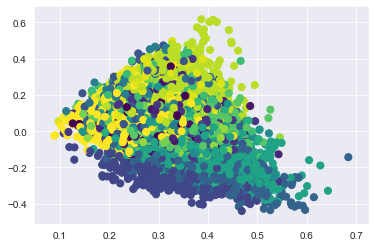

In [27]:
plt.scatter(tfidf_lsa_data[:, 0], tfidf_lsa_data[:, 1], c=predicted, s=50, cmap='viridis');


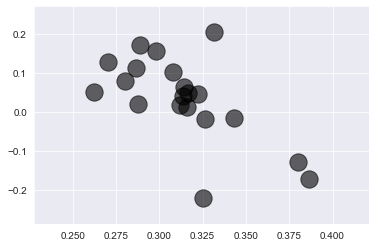

In [28]:
#and if we want to show the centers of our clusters ...
centers = fitted_lsa_tfidf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

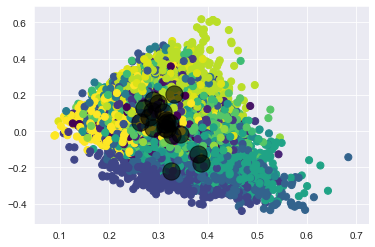

In [29]:
plt.scatter(tfidf_lsa_data[:, 0], tfidf_lsa_data[:, 1], c=predicted, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);


## K-means clustering on tf-idf data with no dimensionality reduction

In [30]:
# Please note that the get_top_features_cluster function is not finished! Although it is currently retrieving seemingly correct results, it is 
# using cluster labelling on decomposed data (be it via PCA or LSA) but then retrieving the features from the data that hasn't undergone decomposition.
# For the moment, I am performing clustering on the undecomposed data and then passing that in, but will return to fix this.
kmeans_tfidf = KMeans(n_clusters=20, max_iter=2000, algorithm = 'auto', random_state=42)
fitted_tfidf = kmeans_tfidf.fit(tfidf_train_sparse.toarray())
predicted_tfidf = kmeans_tfidf.predict(tfidf_train_sparse.toarray())


def get_top_features_cluster(tf_idf_array, prediction, n_feats, tf_idf_vectorizer):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names() #retrieving the columns of the original tfidf data - note this is in alphanumeric order
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = [f'features_cluster_{label}', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array = tfidf_train_sparse.toarray(), 
                               prediction=predicted_tfidf, n_feats=10,
                              tf_idf_vectorizer = tfidf)

In [31]:
pd.concat([dfs[x] for x in range(len(dfs))], axis=1)

features_cluster_0     score features_cluster_1     score  \
0               data  0.425526                car  0.458711   
1                bit  0.065516              would  0.062661   
2              lines  0.057242             writes  0.056427   
3            subject  0.055454                one  0.056154   
4              would  0.054881            article  0.055817   
5       organization  0.052308                get  0.054392   
6                use  0.047740       organization  0.054016   
7             writes  0.043537            subject  0.053202   
8                get  0.043053              lines  0.052623   
9                one  0.040463               good  0.051698   

  features_cluster_2     score features_cluster_3     score  \
0               year  0.325405                new  0.391703   
1               last  0.129283         university  0.083387   
2               good  0.068721       organization  0.071772   
3             writes  0.063577            subject  0.071622   
4            article  0.062905              lines  0.070089   
5              would  0.058506                one  0.047012   
6              think  0.058084            posting  0.045882   
7             better  0.058068              would  0.045577   
8                one  0.056905            article  0.044930   
9              years  0.056034               like  0.044513   

  features_cluster_4     score  ... features_cluster_15     score  \
0               john  0.406976  ...                 usa  0.255502   
1            article  0.075538  ...        distribution  0.135309   
2             writes  0.067190  ...                nntp  0.096700   
3            subject  0.067073  ...                host  0.096260   
4            posting  0.066906  ...             posting  0.095470   
5       organization  0.065927  ...        organization  0.085212   
6              lines  0.064871  ...               lines  0.083838   
7               nntp  0.063858  ...             subject  0.083646   
8               host  0.063049  ...          university  0.079401   
9         university  0.060515  ...              access  0.072322   

  features_cluster_16     score features_cluster_17     score  \
0                 use  0.079556               drive  0.528043   
1               lines  0.063384                hard  0.145608   
2             subject  0.062215               lines  0.053095   
3        organization  0.059368        organization  0.052562   
4             program  0.050502             subject  0.052269   
5                 one  0.049477             problem  0.050766   
6                 get  0.045008          university  0.050572   
7               using  0.044102                nntp  0.046778   
8                like  0.041602                host  0.046527   
9             problem  0.041397             posting  0.046476   

  features_cluster_18     score features_cluster_19     score  
0               would  0.145682             article  0.182508  
1                 one  0.103087              writes  0.172378  
2               think  0.081584             subject  0.071153  
3                like  0.076868        organization  0.070992  
4              people  0.063832               lines  0.069214  
5                 get  0.060518                 one  0.058358  
6                know  0.059231          university  0.053904  
7                even  0.058062               would  0.044622  
8                well  0.056611             posting  0.044130  
9              writes  0.056474                know  0.041656  

[10 rows x 40 columns]

So above we have 20 clusters, each with the 10 most salient features. We re-plot these below as vertical bar plots for clarity... notice any trends?

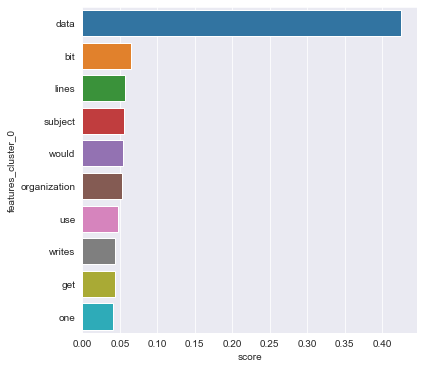

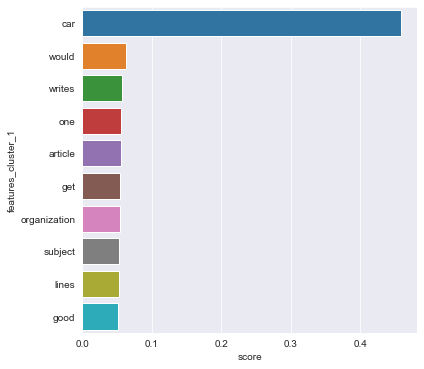

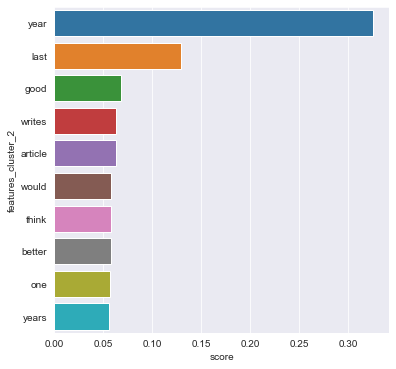

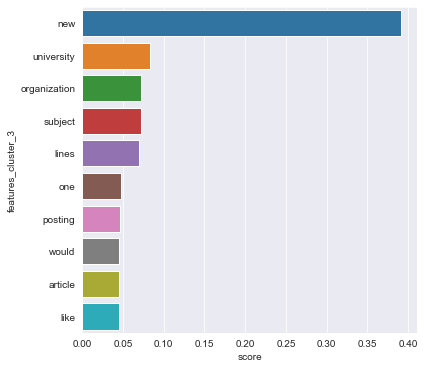

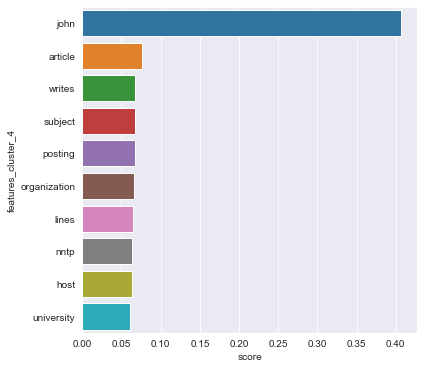

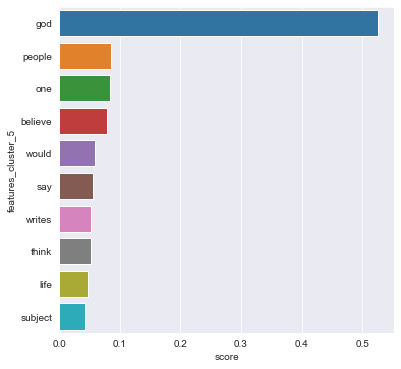

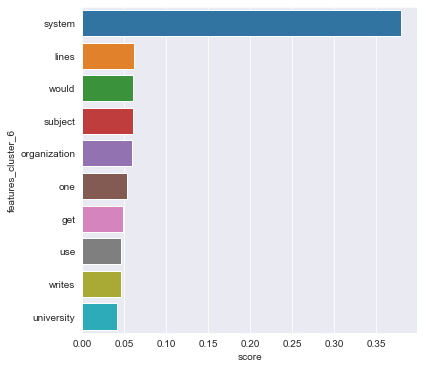

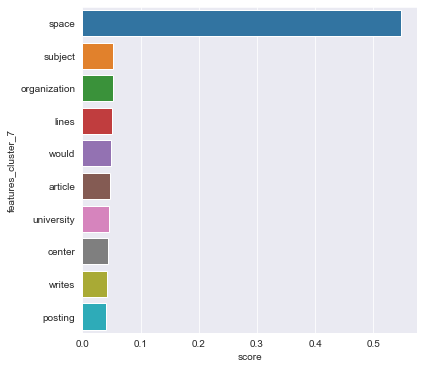

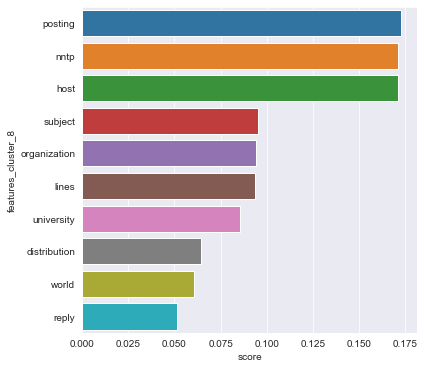

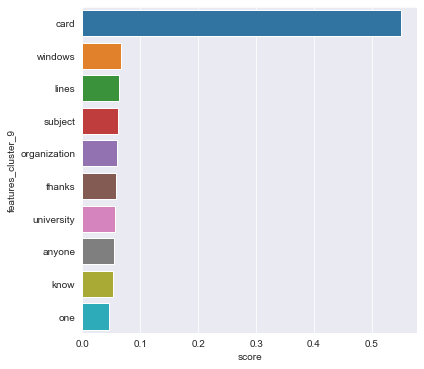

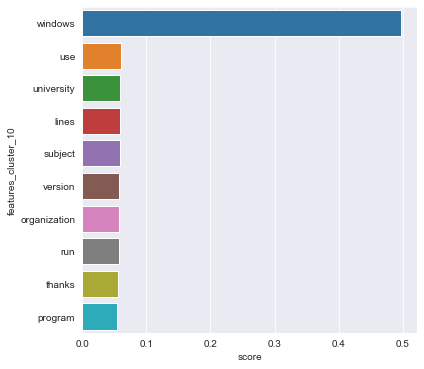

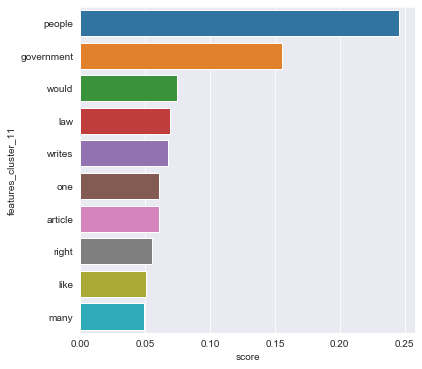

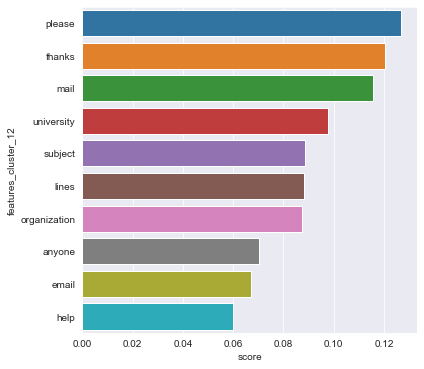

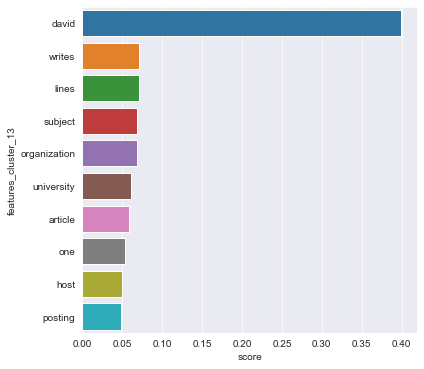

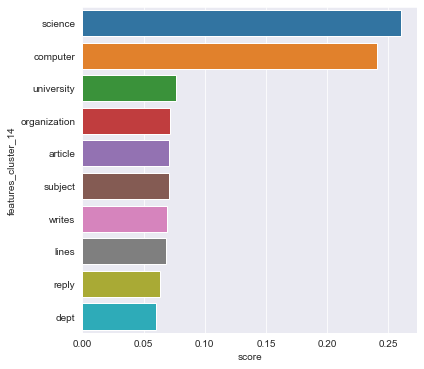

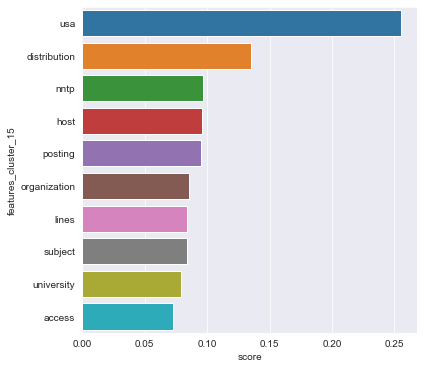

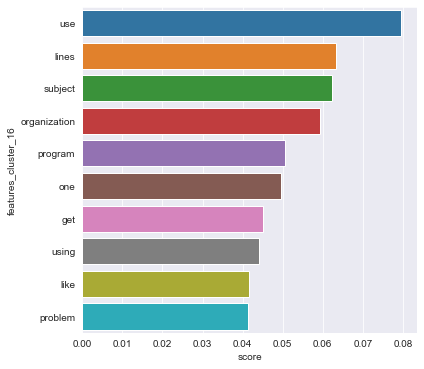

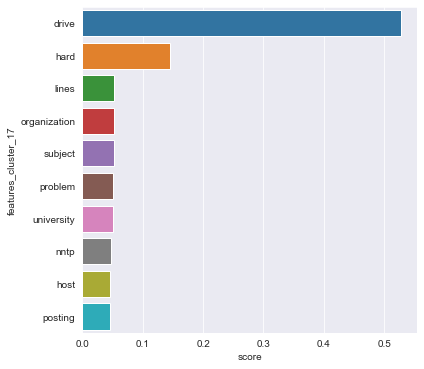

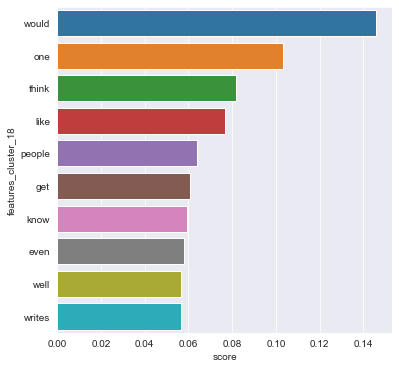

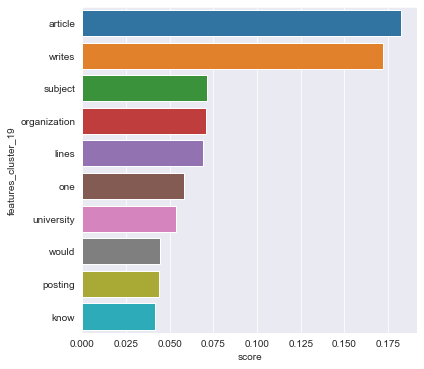

In [32]:
for i in range(len(dfs)):
    plt.figure(figsize=(6,6))
    sns.barplot(y=dfs[i][f'features_cluster_{i}'], x=dfs[i]['score'])
    plt.show();

And now for a reality check: with unsupervised learning tasks there is no ground-truth, no metric or target value to compare against. However, just to show people the potential of clustering finding some patterns, this dataset DOES have target values. There are 20 news categories. Although not all of the cluster features are clear, some are quite coherent, specifically clusters 4 ('space', 'nasa','moon'); 9 ('israel', 'arab', 'policy', 'peace'); 11 ('windows', 'dos', 'file', 'program'); 12, etc... 

Again, please remember that this will almost NEVER be this clean in real-life. There will be no ground truth, so interpretation will be far more subjective AND there is always a chance that what you're looking at is JUST NOISE. Sometimes there will be little to no insights to report.

I've printed the 20 Newsgroups description below - see how many of the news categories we managed to match just through clustering on tfidf data.

In [33]:
d = fetch_20newsgroups()['DESCR']
print(d)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [34]:
silhouette_score(tfidf_train_df, labels=predicted)

0.03205289329729713

The silhouette score doesn't necessarily tell us anything, except that our clusters are quite dispersed, which is to be expected with such sparse, text data. Nevertheless, we were able to gain insights, we just had to look at the top features ourselves. I hope you enjoyed this application of clustering to NLP. 